In [ ]:
!pip install pandas-ta
!pip install yfinance

In [ ]:
# imports
import numpy as np
import pandas as pd
from google.colab import drive
import os
import requests
import logging

# finance
import yfinance as yf
import pandas_datareader as pdr
import pandas_ta as ta

# visualisation
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# time
import time
from datetime import date, datetime, timedelta

# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree, export_text, DecisionTreeClassifier
from sklearn.metrics import precision_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0. Get Data

## 0.1 Get Crypto

In [ ]:
def get_coins():
    # Set up logging to display info and error messages
    logging.basicConfig(
        level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
    )

    # List of coins
    coins = [
        "BTCUSDT",
        "ETHUSDT",
        "BNBUSDT",
        "SOLUSDT",
        "XRPUSDT",
        "DOGEUSDT",
        "ADAUSDT",
        "TRXUSDT",
        "ARBUSDT",
        "SHIBUSDT",
        "WBTCUSDT",
        "DOTUSDT",
        "LINKUSDT",
        "BCHUSDT",
        "UNIUSDT",
        "NEARUSDT",
        "LTCUSDT",
        "FILUSDT",
        "BEAMUSDT",
        "APTUSDT",
        "AVAXUSDT",
        "MATICUSDT",
        "ATOMUSDT",
        "XLMUSDT",
        "RNDRUSDT",
    ]

    def fetch_crypto_ohlc(coin, interval="1h", start_str="1 Jan, 2020"):
        url = "https://api.binance.com/api/v1/klines"

        # Convert start date string to datetime object
        start_time = pd.to_datetime(start_str)
        end_time = datetime.now()

        all_data = []

        while start_time < end_time:
            # Define request parameters for Binance API
            params = {
                "symbol": coin,
                "interval": interval,
                "startTime": int(start_time.timestamp() * 1000),
                "endTime": int(
                    (start_time + timedelta(days=30)).timestamp() * 1000
                ),  # Fetching 30 days at a time
            }

            response = requests.get(url, params=params)

            # Check if request was successful
            if response.status_code != 200:
                logging.error(f"Error fetching data for {coin}: {response.status_code}")
                break

            data = response.json()

            # Check if data is returned
            if not data:
                logging.warning(f"No OHLC data found for {coin}.")
                break

            all_data.extend(data)

            # Update start time for next request
            start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                milliseconds=1
            )

            logging.info(f"Fetched data for {coin} up to {start_time}")
            time.sleep(0.5)  # Pause to avoid API limits

        if not all_data:
            return pd.DataFrame()

        # Convert fetched data into a DataFrame with appropriate column names
        ohlc_df = pd.DataFrame(
            all_data,
            columns=[
                "timestamp",
                "open",
                "high",
                "low",
                "close",
                "volume",
                "close_time",
                "quote_asset_volume",
                "number_of_trades",
                "taker_buy_base_asset_volume",
                "taker_buy_quote_asset_volume",
                "ignore",
            ],
        )

        # Convert timestamp to datetime and set it as index
        ohlc_df["Date"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
        ohlc_df["Ticker"] = coin
        ohlc_df["Ticker_Type"] = "Cryptocurrency"

        # Convert price and volume columns to float
        ohlc_df[["Open", "High", "Low", "Close", "Volume"]] = ohlc_df[
            ["open", "high", "low", "close", "volume"]
        ].astype(float)
        ohlc_df["Adj Close"] = ohlc_df["close"]

        # Setting the timezone to Berlin
        ohlc_df["Date"] = (
            ohlc_df["Date"].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
        )
        ohlc_df.set_index("Date", inplace=True)

        return ohlc_df[
            [
                "Open",
                "High",
                "Low",
                "Close",
                "Adj Close",
                "Volume",
                "Ticker",
                "Ticker_Type",
            ]
        ]

    def generate_datetime_features(df):
        # Generate additional datetime features
        df["Year"] = df.index.year.astype(int)
        df["Month"] = df.index.month.astype(int)
        df["Weekday"] = df.index.weekday.astype(int)
        df["Hour"] = df.index.hour.astype(int)
        df["Coin"] = df["Ticker"].str.replace("USDT", "")  # Extracting Name

        return df

    # Main Script
    all_data = pd.DataFrame()

    for coin in coins:
        logging.info(f"Fetching data for {coin}")
        df = fetch_crypto_ohlc(coin)

        if not df.empty:
            df = generate_datetime_features(df)
            all_data = pd.concat([all_data, df])
        else:
            logging.warning(f"No data fetched for {coin}")

    # Reorder columns to have datetime features at the beginning
    cols = ["Year", "Month", "Weekday", "Hour", "Ticker", "Ticker_Type"] + [
        col
        for col in all_data.columns
        if col not in ["Year", "Month", "Weekday", "Hour", "Ticker", "Ticker_Type"]
    ]
    all_data = all_data[cols]

    # Save the final DataFrame to a CSV file
    all_data.to_csv('/content/crypto.csv', index=True)
    logging.info("Data fetching and processing complete. Data saved to crypto.csv")


if __name__ == "__main__":
    get_coins()

## 0.2 Get Stocks

In [ ]:
# Function to download historical stock data
def get_stats(ticker, period="2y", interval="1h"):
    data = yf.download(ticker, period=period, interval=interval)
    return data


# Adding Date and Time Features
def add_date_features_and_shifts(df):
    # Convert index to datetime and localize to Berlin timezone
    df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.tz_convert("Europe/Berlin")
    df.set_index("Date", inplace=True)
    # Extract year, month, weekday, and hour from the datetime index
    df["Year"] = df.index.year.astype(int)
    df["Month"] = df.index.month.astype(int)
    df["Weekday"] = df.index.weekday.astype(int)
    df["Hour"] = df.index.hour.astype(int)


def top_stocks():
    # Getting top stocks from yahoofinance
    yfinance_most_active_stocks_web = pd.read_html(
        "https://finance.yahoo.com/most-active/?offset=0&count=100"
    )
    FIELDS = ["Symbol", "Name", "Volume"]
    stock_tickers = yfinance_most_active_stocks_web[0][FIELDS]

    # Limit to top 25 most active stocks
    stock_tickers = stock_tickers.head(25)

    # Initialize an empty DataFrame for storing stock data
    stocks_df = None
    period = "2y"
    interval = "1h"

    # Loop through each stock ticker and download data
    for elem in stock_tickers.Symbol.to_list():
        print(f"Downloading stats for stock: {elem}")
        one_ticker_df = get_stats(elem, period=period, interval=interval)
        if one_ticker_df.empty:
            print(f"No data available for stock: {elem}")
            continue
        # Add additional columns to the DataFrame
        one_ticker_df["Date"] = one_ticker_df.index
        one_ticker_df["Ticker"] = elem
        one_ticker_df["Ticker_Type"] = "Stock"
        # Concatenate each stock's data into a single DataFrame
        if stocks_df is None:
            stocks_df = one_ticker_df
        else:
            stocks_df = pd.concat([stocks_df, one_ticker_df], ignore_index=True, axis=0)
        time.sleep(0.5)  # pause to avoid API overload

    # Adding date and time features
    add_date_features_and_shifts(stocks_df)

    # Reorder columns to have date and time features at the beginning
    cols = ["Year", "Month", "Weekday", "Hour", "Ticker", "Ticker_Type"] + [
        col
        for col in stocks_df.columns
        if col not in ["Year", "Month", "Weekday", "Hour", "Ticker", "Ticker_Type"]
    ]
    stocks_df = stocks_df[cols]

    # save DataFrame as csv
    stocks_df.to_csv('/content/stocks.csv', index=True)

    # Print the first few rows
    print(stocks_df.head())


if __name__ == "__main__":
    top_stocks()


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


                           Year  Month  Weekday  Hour Ticker Ticker_Type  \
Date                                                                       
2022-08-03 15:30:00+02:00  2022      8        2    15   NVDA       Stock   
2022-08-03 16:30:00+02:00  2022      8        2    16   NVDA       Stock   
2022-08-03 17:30:00+02:00  2022      8        2    17   NVDA       Stock   
2022-08-03 18:30:00+02:00  2022      8        2    18   NVDA       Stock   
2022-08-03 19:30:00+02:00  2022      8        2    19   NVDA       Stock   

                                Open       High        Low      Close  \
Date                                                                    
2022-08-03 15:30:00+02:00  18.184000  18.691000  18.136999  18.552999   
2022-08-03 16:30:00+02:00  18.552999  18.573000  18.339010  18.513000   
2022-08-03 17:30:00+02:00  18.514000  18.619999  18.482000  18.565910   
2022-08-03 18:30:00+02:00  18.566500  18.803999  18.559010  18.764990   
2022-08-03 19:30:00+02:00  18

# 1. One DataFrame

## 1.1 Calculations on DataFrame

In [ ]:
# Mount your Google Drive
drive.mount('/content/drive')


# Function to add technical indicators to the DataFrame
def add_ta_indicators(df):
    # Ensure the columns have the correct data types
    df["Open"] = df["Open"].astype("float64")
    df["High"] = df["High"].astype("float64")
    df["Low"] = df["Low"].astype("float64")
    df["Close"] = df["Close"].astype("float64")
    df["Volume"] = df["Volume"].astype("float64")

    # Calculate various technical indicators
    df.ta.adx(high="High", low="Low", close="Close", append=True)
    df.ta.aroon(high="High", low="Low", append=True)
    df.ta.bop(open="Open", high="High", low="Low", close="Close", append=True)
    df.ta.cci(high="High", low="Low", close="Close", append=True)
    df.ta.cmo(close="Close", append=True)
    df.ta.macd(close="Close", append=True)
    df.ta.mom(close="Close", append=True)
    df.ta.ppo(close="Close", append=True)
    df.ta.roc(close="Close", append=True)
    df.ta.rsi(close="Close", append=True)
    df.ta.stoch(high="High", low="Low", close="Close", append=True)
    df.ta.willr(high="High", low="Low", close="Close", append=True)
    df.ta.bbands(close="Close", append=True)
    df.ta.dema(close="Close", append=True)
    df.ta.ema(close="Close", append=True)
    df.ta.midpoint(close="Close", append=True)
    df.ta.midprice(high="High", low="Low", append=True)
    df.ta.sma(close="Close", append=True)
    df.ta.tema(close="Close", append=True)
    df.ta.wma(close="Close", append=True)
    df.ta.atr(high="High", low="Low", close="Close", append=True)
    df.ta.trix(close="Close", append=True)
    df.ta.kama(close="Close", append=True)
    df.ta.psar(high="High", low="Low", close="Close", append=True)

    return df


# Function to add custom calculations to the DataFrame
def add_custom_calculations(df, group_by_col="Ticker"):
    new_columns = {}

    # Shifted Close values for previous and next periods
    new_columns["Adj_Close_Minus_1"] = df.groupby(group_by_col)["Close"].shift(-1)
    new_columns["Adj_Close_Plus_1"] = df.groupby(group_by_col)["Close"].shift(1)

    # Growth calculations for different time periods
    for hours in [1, 4, 24, 48, 72, 168, 336, 720]:
        new_columns[f"Growth_{hours}h"] = (
            df.groupby(group_by_col)["Close"].shift(hours) / df["Close"]
        )
        future_shifted = df.groupby(group_by_col)["Close"].shift(-hours)
        new_columns[f"Growth_Future_{hours}h"] = future_shifted / df["Close"]
        new_columns[f"Is_Positive_Growth_{hours}h_Future"] = np.where(
            new_columns[f"Growth_Future_{hours}h"] > 1, 1, 0
        )

    # Fibonacci levels calculation
    new_columns["Fibonacci_0"] = df["Adj Close"]
    new_columns["Fibonacci_23_6"] = df["High"] - (df["High"] - df["Low"]) * 0.236
    new_columns["Fibonacci_38_2"] = df["High"] - (df["High"] - df["Low"]) * 0.382
    new_columns["Fibonacci_50"] = df["High"] - (df["High"] - df["Low"]) * 0.5
    new_columns["Fibonacci_61_8"] = df["High"] - (df["High"] - df["Low"]) * 0.618
    new_columns["Fibonacci_100"] = df["Low"]

    # Assign new columns to the DataFrame
    df = df.assign(**new_columns)

    return df


# Function to fetch market indices data from Yahoo Finance
def fetch_market_indices(market_indices):
    indices_data = {}
    for index in market_indices:
        # Download historical data for each index
        data = yf.download(index, period="1y", interval="1h")
        # Convert timezone and round to the nearest 30 minutes
        data.index = data.index.tz_convert("Europe/Berlin").round("30min")
        # Keep only the adjusted close price and rename it to the index symbol
        data = data[["Adj Close"]].rename(columns={"Adj Close": index})
        indices_data[index] = data
    # Combine all indices data into a single DataFrame
    combined_indices = pd.concat(indices_data.values(), axis=1)
    return combined_indices


def calculations():
    # Load CSV files
    crypto_df = pd.read_csv('/content/drive/My Drive/crypto.csv')
    stocks_df = pd.read_csv('/content/drive/My Drive/stocks.csv')

    #making sure nothing got lost
    unique_coins_before = crypto_df["Ticker"].nunique()
    unique_stocks_before = stocks_df["Ticker"].nunique()
    print(f"Number of unique ticker before combining: {unique_coins_before}")
    print(f"Number of unique ticker before combining: {unique_stocks_before}")

    # Concatenate the DataFrames
    combined_df = pd.concat([crypto_df, stocks_df], ignore_index=True)

    # After merging and processing
    num_unique_coins_after = combined_df[
        combined_df["Ticker_Type"] == "Cryptocurrency"
    ]["Ticker"].nunique()
    num_unique_stocks_after = combined_df[combined_df["Ticker_Type"] == "Stock"][
        "Ticker"
    ].nunique()

    print(f"Number of unique coins after processing: {num_unique_coins_after}")
    print(f"Number of unique stocks after processing: {num_unique_stocks_after}")

    # Add technical indicators to the combined DataFrame
    combined_df = add_ta_indicators(combined_df)

    # Add custom calculations to the combined DataFrame
    combined_df = add_custom_calculations(combined_df)

    # Fetch market indices data and round timestamps to the nearest 30 minutes
    market_indices = ["^GSPC", "^IXIC", "^RUT", "^DJI", "^SPX", "^VIX"]
    indices_df = fetch_market_indices(market_indices)

    # Merge the market indices data with the combined DataFrame
    combined_df["Date"] = pd.to_datetime(combined_df["Date"], utc=True).dt.tz_convert(
        "Europe/Berlin"
    )
    combined_df.set_index("Date", inplace=True)
    combined_df = combined_df.join(indices_df, how="left")

    # Function to check for completely empty columns
    def check_completely_empty_columns(df):
        completely_empty_columns = df.columns[df.isnull().all()].tolist()
        return completely_empty_columns

    # Function to check for columns with only zero values
    def check_zero_only_columns(df):
        zero_only_columns = df.columns[(df == 0).all()].tolist()
        return zero_only_columns

    # Function to count unique tickers and number of non-null entries for market indices
    def ticker_and_market_index_summary(df, market_indices):
        ticker_count = df["Ticker"].nunique()
        market_index_summary = df[market_indices].count()
        return ticker_count, market_index_summary

    # Perform checks on the combined DataFrame
    completely_empty_columns = check_completely_empty_columns(combined_df)
    zero_only_columns = check_zero_only_columns(combined_df)
    ticker_count, market_index_summary = ticker_and_market_index_summary(
        combined_df, market_indices
    )

    # Save the combined DataFrame to a CSV file
    combined_df.to_csv('/content/everything_data.csv')

    # Print the results of the checks
    print("Processing complete and data saved!")
    print("Columns that are completely empty:", completely_empty_columns)
    print("Columns with only zero values:", zero_only_columns)
    print("Number of unique tickers:", ticker_count)
    print("Number of non-null entries for each market index:")
    print(market_index_summary)


if __name__ == "__main__":
    calculations()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Market indices successfully added and saved!
Columns that are completely empty: []
Columns with just Zero: []
combined_df head:                            Year  Month  Weekday  Hour   Ticker  \
Date                                                             
2020-01-01 01:00:00+01:00  2020      1        2     1  BTCUSDT   
2020-01-01 02:00:00+01:00  2020      1        2     2  BTCUSDT   

                              Ticker_Type     Open     High      Low    Close  \
Date                                                                            
2020-01-01 01:00:00+01:00  Cryptocurrency  7195.24  7196.25  7175.46  7177.02   
2020-01-01 02:00:00+01:00  Cryptocurrency  7176.47  7230.00  7175.71  7216.27   

                           ...  Is_Positive_Growth_336h_Future  Growth_720h  \
Date                       ...                                                
2020-01-01 01:00:00+01:00  ...                               1          NaN   
2020-01-01 02:00:00+01:00  ...               

In [ ]:
combined_df.info()

Mounted at /content/drive


<ipython-input-2-ddd654f7a457>:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('/content/drive/My Drive/everything_data.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634027 entries, 0 to 634026
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      634027 non-null  int64  
 1   Date                            634027 non-null  object 
 2   Year                            634027 non-null  int64  
 3   Month                           634027 non-null  int64  
 4   Weekday                         634027 non-null  int64  
 5   Hour                            634027 non-null  int64  
 6   Ticker                          634027 non-null  object 
 7   Ticker_Type                     634027 non-null  object 
 8   Open                            634027 non-null  float64
 9   High                            634027 non-null  float64
 10  Low                             634027 non-null  float64
 11  Close                           634027 non-null  float64
 12  Adj Close       

## 1.2 Truncate Data

In [ ]:
# Function to reduce memory usage of a DataFrame by optimizing data types
def reduce_mem_usage(df):
  # Calculate and print the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Starting memory usage: {start_mem:.2f} MB')

    # Iterate over each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Skip the column named 'date' (assumed to be in datetime format)
        if col != 'date':
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()

                # Optimize integer columns
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)
                # Optimize float columns
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            # If column is of type 'object', no type conversion is applied
            else:
                pass

    # Calculate and print the ending memory usage of the DataFrame
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Ending memory usage: {end_mem:.2f} MB')
    # Print the percentage reduction in memory usage
    print(f'Memory reduction: {100 * (start_mem - end_mem) / start_mem:.1f}%')

    return df

# Apply memory reduction function to the DataFrame
reduced_df = reduce_mem_usage(combined_df)

Starting memory usage: 459.54 MB
Ending memory usage: 157.21 MB
Memory reduction: 65.8%


In [ ]:
print(reduced_df.dtypes)

Date                object
Year                 int16
Month                 int8
Weekday               int8
Hour                  int8
                    ...   
KAMA_10_2_30       float32
PSARl_0.02_0.2     float32
PSARs_0.02_0.2     float32
PSARaf_0.02_0.2    float16
PSARr_0.02_0.2        int8
Length: 94, dtype: object


In [ ]:
# Growth Indicators (but not future growth)
GROWTH = [g for g in reduced_df.keys() if (g.find('Growth_')==0)&(g.find('Future')<0)]
GROWTH

['Growth_1h',
 'Growth_4h',
 'Growth_24h',
 'Growth_48h',
 'Growth_72h',
 'Growth_168h',
 'Growth_336h',
 'Growth_720h']

In [ ]:
OHLCV = ['Open','High','Low','Close','Adj Close','Close', 'Volume', 'Close_Minus_1', 'Close_Plus_1']

In [ ]:
CATEGORICAL = ["Ticker", "Ticker_Type", "Coin"]

In [ ]:
TO_PREDICT = [g for g in reduced_df.keys() if (g.find('Future')>=0)]
TO_PREDICT

['Growth_Future_1h',
 'Is_Positive_Growth_1h_Future',
 'Growth_Future_4h',
 'Is_Positive_Growth_4h_Future',
 'Growth_Future_24h',
 'Is_Positive_Growth_24h_Future',
 'Growth_Future_48h',
 'Is_Positive_Growth_48h_Future',
 'Growth_Future_72h',
 'Is_Positive_Growth_72h_Future',
 'Growth_Future_168h',
 'Is_Positive_Growth_168h_Future',
 'Growth_Future_336h',
 'Is_Positive_Growth_336h_Future',
 'Growth_Future_720h',
 'Is_Positive_Growth_720h_Future']

In [ ]:
TO_DROP = ['Year','Date'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'Ticker',
 'Ticker_Type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Close',
 'Volume',
 'Close_Minus_1',
 'Close_Plus_1',
 'Coin',
 'Unnamed: 0']

In [ ]:
# Function to safely compute the logarithm of a value
def safe_log(x):
    # Return the natural logarithm of x if x is positive, otherwise return NaN
    if x > 0:
        return np.log(x)
    else:
        return np.nan

reduced_df['Ln_Volume'] = reduced_df['Volume'].apply(safe_log)

In [ ]:
CUSTOM_NUMERICAL = ['Ln_Volume', 'Adj_Close_Minus_1', 'Hour', 'Month', 'Weekday', 'Adj_Close_Plus_1', 'Close_^GSPC', 'Close_^IXIC', 'Close_^RUT', 'Close_^DJI', 'Close_^SPX', 'Close_^VIX']

In [ ]:
TECHNICAL_INDICATORS = [
 'ADX_14',
 'ATRr_14',
 'TRIX_30_9',
 'TRIXs_30_9',
 'KAMA_10_2_30',
 'PSARl_0.02_0.2',
 'PSARs_0.02_0.2',
 'PSARaf_0.02_0.2',
 'PSARr_0.02_0.2',
 'WMA_10',
 'DMP_14',
 'DMN_14',
 'AROOND_14',
 'AROONU_14',
 'AROONOSC_14',
 'BOP',
 'CCI_14_0.015',
 'CMO_14',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'MFI_14',
 'MOM_10',
 'PPO_12_26_9',
 'PPOh_12_26_9',
 'PPOs_12_26_9',
 'ROC_10',
 'RSI_14',
 'STOCHk_14_3_3',
 'STOCHd_14_3_3',
 'WILLR_14',
 'BBL_5_2.0',
 'BBM_5_2.0',
 'BBU_5_2.0',
 'BBB_5_2.0',
 'BBP_5_2.0',
 'DEMA_10',
 'EMA_10',
 'MIDPOINT_2',
 'MIDPRICE_2',
 'SMA_10',
 'TEMA_10',
 'WMA_10',
  'Fibonacci_0',
 'Fibonacci_23_6',
 'Fibonacci_38_2',
 'Fibonacci_50',
 'Fibonacci_61_8',
 'Fibonacci_100']

In [ ]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + CUSTOM_NUMERICAL

In [ ]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in reduced_df.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [ ]:
print(reduced_df.Ticker.nunique())
reduced_df.tail(1)

39


,Date,Year,Month,Weekday,Hour,Ticker,Ticker_Type,Open,High,Low,...,WMA_10,ATRr_14,TRIX_30_9,TRIXs_30_9,KAMA_10_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,Ln_Volume
634026,2024-07-25 21:30:00+02:00,2024,7,3,21,PFE,Stock,30.375,30.3899,30.18,...,30.324467,0.234009,0.053741,0.052338,30.24008,30.143055,NaN,0.099976,0,15.478595


## 1.2 Dummies

In [ ]:
reduced_df['Date'] = pd.to_datetime(reduced_df['Date'], errors='coerce')

# Define week of the month
if 'Date' in reduced_df.columns:
    reduced_df['WoM'] = reduced_df['Date'].apply(lambda d: (d.day-1)//7 + 1)
else:
    print("The column 'Date' is not present.")

# Ensure 'WoM' is an integer
if 'WoM' in reduced_df.columns:
    reduced_df['WoM'] = reduced_df['WoM'].astype(int, errors='ignore')
    reduced_df['Month_WoM'] = reduced_df['Month'] * 10 + reduced_df['WoM']
    del reduced_df['WoM']
else:
    print("The column 'WoM' could not be created.")

DUMMIES = []
new_dummy = ['Month_WoM'] + CATEGORICAL
new_dummy_variables = pd.get_dummies(reduced_df[new_dummy], dtype='int32')

# Add Dummy-Variables to DUMMIES
DUMMIES.extend(new_dummy_variables.keys().to_list())

# Concat Dummy with DataFrame
df_with_dummies = pd.concat([reduced_df, new_dummy_variables], axis=1)

# View resulting DataFrame
print(f"Dummie DF: {df_with_dummies.tail(1)}")


<ipython-input-14-e3dd557ee98e>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  reduced_df['Date'] = pd.to_datetime(reduced_df['Date'], errors='coerce')


Dummie DF:                              Date  Year  Month  Weekday  Hour Ticker  \
634026  2024-07-25 21:30:00+02:00  2024      7        3    21    PFE   

       Ticker_Type    Open     High    Low  ...  Ticker_SIRI  Ticker_SOFI  \
634026       Stock  30.375  30.3899  30.18  ...            0            0   

        Ticker_SWN Ticker_T  Ticker_TRXUSDT  Ticker_TSLA  Ticker_XLMUSDT  \
634026           0        0               0            0               0   

        Ticker_XRPUSDT  Ticker_Type_Cryptocurrency  Ticker_Type_Stock  
634026               0                           0                  1  

[1 rows x 138 columns]


In [ ]:
print(df_with_dummies.dtypes)
print(f"Index: {df_with_dummies.index}")

Date                          object
Year                           int16
Month                           int8
Weekday                         int8
Hour                            int8
                               ...  
Ticker_TSLA                    int32
Ticker_XLMUSDT                 int32
Ticker_XRPUSDT                 int32
Ticker_Type_Cryptocurrency     int32
Ticker_Type_Stock              int32
Length: 140, dtype: object
Index: RangeIndex(start=0, stop=634027, step=1)


In [ ]:
# Converting Date to right Format
df_with_dummies['Date'] = pd.to_datetime(df_with_dummies['Date'], utc=True).dt.tz_convert('Europe/Berlin')

# Function to add black swan events to a DataFrame
def add_black_swan_events(df):
    # List of significant black swan events with their dates
    black_swan_events = [
       # All the dates, commented out what is too far back for the DF
       # {"Event": "Chinese Central Bank Bans Financial Institutions from Bitcoin Transactions", "Date": "2013-12-05"},
       # {"Event": "MT. Gox Bancruptcy", "Date": "2014-02-24"},
       # {"Event": "DAO Hack", "Date": "2016-06-17"},
       # {"Event": "Chinese Central Bank Inspects Bitcoin Exchanges", "Date": "2017-01-05"},
       # {"Event": "China ICO Ban", "Date": "2017-09-04"},
       # {"Event": "South Korea Regulation of Cryptocurrency", "Date": "2017-12-28"},
        {"Event": "COVID-19 Market Crash", "Date": "2020-03-12"},
        {"Event": "Elon Musk halts BTC acceptance", "Date": "2021-05-12"},
        {"Event": "China Regulations on Mining Operations", "Date": "2021-05-19"},
        {"Event": "China Crypto Ban Announcement", "Date": "2021-09-20"},
        {"Event": "Omicron COVID-19 Variant Impact on USA", "Date": "2021-12-03"},
        {"Event": "Federal Crypto Regulations due to Russia Sanctions", "Date": "2022-03-02"},
        {"Event": "Luna Depagging from USDT", "Date": "2022-05-05"},
        {"Event": "Celsius Network Bankruptcy", "Date": "2022-06-13"},
        {"Event": "FTX Exchange Collapse", "Date": "2022-11-08"},
        {"Event": "MT. Gox moves BTC for Payout", "Date": "2022-05-07"},
        {"Event": "Germany moves 1300 BTC", "Date": "2022-05-07"},
    ]
    # Iterate over each black swan event
    for event in black_swan_events:
        event_date = pd.to_datetime(event['Date'], utc=True).tz_convert('Europe/Berlin')
        event_name = event['Event']
        window = pd.Timedelta(days=7)
        # Add a new column to the DataFrame indicating whether the date falls within the event window
        df[event_name] = ((df['Date'] >= (event_date - window)) & (df['Date'] <= (event_date + window))).astype(int)
    return df

# Function to add Bitcoin halving events to a DataFrame
def add_bitcoin_halvings(df):
    bitcoin_halvings = [
        #{"Event": "Bitcoin Halving 1", "Date": "2012-11-28"}, date too far back for df
        #{"Event": "Bitcoin Halving 2", "Date": "2016-07-09"}, date too far back for df
        {"Event": "Bitcoin Halving 3", "Date": "2020-05-11"},
        {"Event": "Bitcoin Halving 4", "Date": "2024-04-08"},
    ]
    # Iterate over each Bitcoin halving event
    for event in bitcoin_halvings:
        event_date = pd.to_datetime(event['Date'], utc=True).tz_convert('Europe/Berlin')
        event_name = event['Event']
        window = pd.Timedelta(days=7)
        # Add a new column to the DataFrame indicating whether the date falls within the event window
        df[event_name] = ((df['Date'] >= (event_date - window)) & (df['Date'] <= (event_date + window))).astype(int)
    return df

# Treating missing values
def treat_missing_values(df: pd.DataFrame):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

# Applying Functions to DataFrame
df_with_dummies = add_black_swan_events(df_with_dummies)
df_with_dummies = add_bitcoin_halvings(df_with_dummies)
df_with_dummies = treat_missing_values(df_with_dummies)

# Show Results
pd.set_option('display.max_columns', None)
print(df_with_dummies.columns)
print(df_with_dummies.head(2))

DUMMIES.extend(df_with_dummies.columns[df_with_dummies.columns.str.contains('COVID-19 Market Crash|Elon Musk halts BTC acceptance|China Regulations on Mining Operations|China Crypto Ban Announcement|Omicron COVID-19 Variant Impact on USA|Federal Crypto Regulations due to Russia Sanctions|Luna Depagging from USDT|Celsius Network Bankruptcy|FTX Exchange Collapse|MT. Gox moves BTC for Payout|Germany moves 1300 BTC|Bitcoin Halving 3|Bitcoin Halving 4')].tolist())


Index(['Date', 'Year', 'Month', 'Weekday', 'Hour', 'Ticker', 'Ticker_Type',
       'Open', 'High', 'Low',
       ...
       'China Crypto Ban Announcement',
       'Omicron COVID-19 Variant Impact on USA',
       'Federal Crypto Regulations due to Russia Sanctions',
       'Luna Depagging from USDT', 'Celsius Network Bankruptcy',
       'FTX Exchange Collapse', 'MT. Gox moves BTC for Payout',
       'Germany moves 1300 BTC', 'Bitcoin Halving 3', 'Bitcoin Halving 4'],
      dtype='object', length=151)
                       Date  Year  Month  Weekday  Hour   Ticker  \
0 2020-01-01 01:00:00+01:00  2020      1        2     1  BTCUSDT   
1 2020-01-01 02:00:00+01:00  2020      1        2     2  BTCUSDT   

      Ticker_Type         Open     High          Low       Close   Adj Close  \
0  Cryptocurrency  7195.240234  7196.25  7175.459961  7177.02002  7177.02002   
1  Cryptocurrency  7176.470215  7230.00  7175.709961  7216.27002  7216.27002   

       Volume Coin  Close_^GSPC  Close_^IXIC  Cl

In [ ]:
# Add new features
# RSI binned, with transformed float for pd.cut function
df_with_dummies['RSI_14'] = df_with_dummies['RSI_14'].astype('float32')
if 'RSI_14' in df_with_dummies.columns:
    df_with_dummies['RSI_binned'] = pd.cut(df_with_dummies['RSI_14'], bins=[0, 30, 70, 100], labels=['oversold', 'neutral', 'overbought'])
else:
    print("RSI_14 column not found in DataFrame")

# Pct Change
if 'Close' in df_with_dummies.columns:
    df_with_dummies['Pct_Change'] = df_with_dummies['Close'].pct_change()
else:
    print("Close column not found in DataFrame")

# MACD and MACD binned
if 'MACD_12_26_9' in df_with_dummies.columns and 'MACDs_12_26_9' in df_with_dummies.columns and 'MACDh_12_26_9' in df_with_dummies.columns:
    df_with_dummies['MACD_12_26_9'] = df_with_dummies['MACD_12_26_9'].astype('float32')
    df_with_dummies['MACDs_12_26_9'] = df_with_dummies['MACDs_12_26_9'].astype('float32')
    df_with_dummies['MACDh_12_26_9'] = df_with_dummies['MACDh_12_26_9'].astype('float32')
    df_with_dummies['MACD'], df_with_dummies['MACD_signal'], df_with_dummies['MACD_hist'] = df_with_dummies['MACD_12_26_9'], df_with_dummies['MACDs_12_26_9'], df_with_dummies['MACDh_12_26_9']
    df_with_dummies['MACD_binned'] = pd.cut(df_with_dummies['MACD'], bins=[-np.inf, -0.5, 0.5, np.inf], labels=['sell', 'neutral', 'buy'])
else:
    print("MACD columns not found in DataFrame")

# ADX binned
if 'ADX_14' in df_with_dummies.columns:
    df_with_dummies['ADX_14'] = df_with_dummies['ADX_14'].astype('float32')
    df_with_dummies['ADX_binned'] = pd.cut(df_with_dummies['ADX_14'], bins=[0, 25, 50, 75, 100], labels=['weak', 'moderate', 'strong', 'very strong'])
else:
    print("ADX_14 column not found in DataFrame")

# Volume binned
if 'Volume' in df_with_dummies.columns:
    df_with_dummies['Volume'] = df_with_dummies['Volume'].astype('float32')
    df_with_dummies['Volume_binned'] = pd.cut(df_with_dummies['Volume'], bins=[0, df_with_dummies['Volume'].quantile(0.33), df_with_dummies['Volume'].quantile(0.66), np.inf], labels=['low', 'medium', 'high'])
else:
    print("Volume column not found in DataFrame")

# Aroon Oscillator binned
if 'AROONOSC_14' in df_with_dummies.columns:
    df_with_dummies['AROONOSC_14'] = df_with_dummies['AROONOSC_14'].astype('float32')
    df_with_dummies['Aroon_binned'] = pd.cut(df_with_dummies['AROONOSC_14'], bins=[-100, -50, 50, 100], labels=['downtrend', 'neutral', 'uptrend'])
else:
    print("AROONOSC_14 column not found in DataFrame")

# Bollinger Bands Percentage binned
if 'BBP_5_2.0' in df_with_dummies.columns:
    df_with_dummies['BBP_5_2.0'] = df_with_dummies['BBP_5_2.0'].astype('float32')
    df_with_dummies['BBP_binned'] = pd.cut(df_with_dummies['BBP_5_2.0'], bins=[0, 0.2, 0.8, 1], labels=['low', 'medium', 'high'])
else:
    print("BBP_5_2.0 column not found in DataFrame")

# SMA cross
if 'Close' in df_with_dummies.columns:
    df_with_dummies['SMA_50'] = df_with_dummies['Close'].rolling(window=50).mean()
    df_with_dummies['SMA_200'] = df_with_dummies['Close'].rolling(window=200).mean()
    df_with_dummies['SMA_Cross'] = df_with_dummies['SMA_50'] - df_with_dummies['SMA_200']
else:
    print("Close column not found in DataFrame")

# Drop rows with NaN values in new features if necessary
new_features = ['Pct_Change', 'SMA_Cross']# you see the all features printed before binning, this was corrected hier afterwards
df_with_dummies.dropna(subset=new_features, inplace=True)

# Generate dummy variables for the new binned features
new_categorical = ['RSI_binned', 'MACD_binned', 'ADX_binned', 'Volume_binned', 'Aroon_binned', 'BBP_binned']
new_dummy_variables = pd.get_dummies(df_with_dummies[new_categorical], dtype='int32')

# Concatenate the new dummy variables with the original DataFrame
df_with_all_dummies = pd.concat([df_with_dummies, new_dummy_variables], axis=1)

df_with_all_dummies = df_with_all_dummies.reset_index(drop=True)


pd.set_option('display.max_columns', None)
print(df_with_all_dummies.head(2))


                       Date  Year  Month  Weekday  Hour   Ticker  \
0 2020-01-09 08:00:00+01:00  2020      1        3     8  BTCUSDT   
1 2020-01-09 09:00:00+01:00  2020      1        3     9  BTCUSDT   

      Ticker_Type         Open         High          Low        Close  \
0  Cryptocurrency  7908.709961  7976.669922  7903.399902  7949.839844   
1  Cryptocurrency  7949.569824  7955.830078  7909.299805  7933.100098   

     Adj Close       Volume Coin  Close_^GSPC  Close_^IXIC  Close_^RUT  \
0  7949.839844  2449.538330  BTC          0.0          0.0         0.0   
1  7933.100098  1641.494385  BTC          0.0          0.0         0.0   

   Close_^DJI  Close_^SPX  Close_^VIX  Adj_Close_Minus_1  Adj_Close_Plus_1  \
0         0.0         0.0         0.0        7933.100098       7908.479980   
1         0.0         0.0         0.0        7872.350098       7949.839844   

   Growth_1h  Growth_Future_1h  Is_Positive_Growth_1h_Future  Growth_4h  \
0   0.994629          0.998047            

In [ ]:
NUMERICAL.extend([
    'Pct_Change',
    'SMA_50',
    'SMA_200',
    'SMA_Cross'
])

DUMMIES.extend([
    'RSI_binned_oversold',
    'RSI_binned_neutral',
    'RSI_binned_overbought',
    'MACD_binned_sell',
    'MACD_binned_neutral',
    'MACD_binned_buy',
    'ADX_binned_weak',
    'ADX_binned_moderate',
    'ADX_binned_strong',
    'ADX_binned_very strong',
    'Volume_binned_low',
    'Volume_binned_medium',
    'Volume_binned_high',
    'Aroon_binned_downtrend',
    'Aroon_binned_neutral',
    'Aroon_binned_uptrend',
    'BBP_binned_low',
    'BBP_binned_medium',
    'BBP_binned_high'
])

In [ ]:
NUMERICAL

['Growth_1h',
 'Growth_4h',
 'Growth_24h',
 'Growth_48h',
 'Growth_72h',
 'Growth_168h',
 'Growth_336h',
 'Growth_720h',
 'ADX_14',
 'ATRr_14',
 'TRIX_30_9',
 'TRIXs_30_9',
 'KAMA_10_2_30',
 'PSARl_0.02_0.2',
 'PSARs_0.02_0.2',
 'PSARaf_0.02_0.2',
 'PSARr_0.02_0.2',
 'WMA_10',
 'DMP_14',
 'DMN_14',
 'AROOND_14',
 'AROONU_14',
 'AROONOSC_14',
 'BOP',
 'CCI_14_0.015',
 'CMO_14',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'MFI_14',
 'MOM_10',
 'PPO_12_26_9',
 'PPOh_12_26_9',
 'PPOs_12_26_9',
 'ROC_10',
 'RSI_14',
 'STOCHk_14_3_3',
 'STOCHd_14_3_3',
 'WILLR_14',
 'BBL_5_2.0',
 'BBM_5_2.0',
 'BBU_5_2.0',
 'BBB_5_2.0',
 'BBP_5_2.0',
 'DEMA_10',
 'EMA_10',
 'MIDPOINT_2',
 'MIDPRICE_2',
 'SMA_10',
 'TEMA_10',
 'WMA_10',
 'Fibonacci_0',
 'Fibonacci_23_6',
 'Fibonacci_38_2',
 'Fibonacci_50',
 'Fibonacci_61_8',
 'Fibonacci_100',
 'Ln_Volume',
 'Adj_Close_Minus_1',
 'Hour',
 'Month',
 'Weekday',
 'Adj_Close_Plus_1',
 'Close_^GSPC',
 'Close_^IXIC',
 'Close_^RUT',
 'Close_^DJI',
 'Close_^

In [ ]:
DUMMIES

['Month_WoM',
 'Ticker_AAL',
 'Ticker_AAPL',
 'Ticker_ADAUSDT',
 'Ticker_AMD',
 'Ticker_AMZN',
 'Ticker_ATOMUSDT',
 'Ticker_AVTR',
 'Ticker_BAC',
 'Ticker_BCHUSDT',
 'Ticker_BEAMUSDT',
 'Ticker_BNBUSDT',
 'Ticker_BTCUSDT',
 'Ticker_CMG',
 'Ticker_DOGEUSDT',
 'Ticker_ET',
 'Ticker_ETHUSDT',
 'Ticker_ETRN',
 'Ticker_EW',
 'Ticker_F',
 'Ticker_GOOGL',
 'Ticker_INTC',
 'Ticker_LCID',
 'Ticker_LINKUSDT',
 'Ticker_LTCUSDT',
 'Ticker_MARA',
 'Ticker_MATICUSDT',
 'Ticker_NIO',
 'Ticker_NVDA',
 'Ticker_PFE',
 'Ticker_PLTR',
 'Ticker_RIG',
 'Ticker_SIRI',
 'Ticker_SOFI',
 'Ticker_SWN',
 'Ticker_T',
 'Ticker_TRXUSDT',
 'Ticker_TSLA',
 'Ticker_XLMUSDT',
 'Ticker_XRPUSDT',
 'Ticker_Type_Cryptocurrency',
 'Ticker_Type_Stock',
 'COVID-19 Market Crash',
 'Elon Musk halts BTC acceptance',
 'China Regulations on Mining Operations',
 'China Crypto Ban Announcement',
 'Omicron COVID-19 Variant Impact on USA',
 'Federal Crypto Regulations due to Russia Sanctions',
 'Luna Depagging from USDT',
 'Celsius Net

## 1.3 Temporal Split

In [ ]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.7).
        val_prop (float): Proportion of data for validation set (default: 0.15).
        test_prop (float): Proportion of data for test set (default: 0.15).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('Train')
        elif date <= val_end:
            split_labels.append('Validation')
        else:
            split_labels.append('Test')

    # Add 'split' column to the DataFrame
    df['Split'] = split_labels

    return df

In [ ]:
min_date_df = df_with_all_dummies.Date.min()
max_date_df = df_with_all_dummies.Date.max()

df_with_all_dummies = temporal_split(df_with_all_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [ ]:
df_with_all_dummies['Split'].value_counts()/len(df_with_all_dummies)

,count
Split,
Train,0.624535
Test,0.187896
Validation,0.187569


In [ ]:
new_df = df_with_all_dummies.copy()

In [ ]:
new_df.groupby(['Split'])['Date'].agg({'min','max','count'})

,count,max,min
Split,,,
Test,68504,2024-07-25 21:30:00+02:00,2023-11-18 00:00:00+01:00
Train,227696,2023-03-12 22:00:00+01:00,2020-01-01 01:00:00+01:00
Validation,68385,2023-11-17 23:00:00+01:00,2023-03-12 23:00:00+01:00


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364585 entries, 0 to 364584
Columns: 184 entries, Date to Split
dtypes: category(6), datetime64[ns, Europe/Berlin](1), float16(52), float32(29), float64(4), int16(1), int32(60), int64(15), int8(12), object(4)
memory usage: 233.7+ MB


In [ ]:
pd.set_option('display.max_columns', None)
print(new_df.tail(1))

                            Date  Year  Month  Weekday  Hour Ticker  \
364584 2024-07-25 21:30:00+02:00  2024      7        3    21    PFE   

       Ticker_Type    Open     High    Low  Close  Adj Close     Volume Coin  \
364584       Stock  30.375  30.3899  30.18  30.18      30.18  5275558.0    0   

        Close_^GSPC  Close_^IXIC  Close_^RUT  Close_^DJI  Close_^SPX  \
364584       5400.0      17168.0      2222.0     39936.0      5400.0   

        Close_^VIX  Adj_Close_Minus_1  Adj_Close_Plus_1  Growth_1h  \
364584         0.0                0.0            30.375   1.006836   

        Growth_Future_1h  Is_Positive_Growth_1h_Future  Growth_4h  \
364584               0.0                             0   1.009766   

        Growth_Future_4h  Is_Positive_Growth_4h_Future  Growth_24h  \
364584               0.0                             0     0.97998   

        Growth_Future_24h  Is_Positive_Growth_24h_Future  Growth_48h  \
364584                0.0                              0  

In [ ]:
new_df[TO_PREDICT].head(3)

,Growth_Future_1h,Is_Positive_Growth_1h_Future,Growth_Future_4h,Is_Positive_Growth_4h_Future,Growth_Future_24h,Is_Positive_Growth_24h_Future,Growth_Future_48h,Is_Positive_Growth_48h_Future,Growth_Future_72h,Is_Positive_Growth_72h_Future,Growth_Future_168h,Is_Positive_Growth_168h_Future,Growth_Future_336h,Is_Positive_Growth_336h_Future,Growth_Future_720h,Is_Positive_Growth_720h_Future
0,0.998047,0,0.991211,0,0.975098,0,1.015625,1,1.018555,1,1.091797,1,1.079102,1,1.229492,1
1,0.992188,0,0.996094,0,0.971680,0,1.014648,1,1.026367,1,1.093750,1,1.073242,1,1.236328,1
2,1.002930,1,1.002930,1,0.979980,0,1.030273,1,1.033203,1,1.098633,1,1.072266,1,1.246094,1


In [ ]:
corr_is_positive_growth_1h_future = new_df[TO_PREDICT].corr()['Is_Positive_Growth_1h_Future']
corr_is_positive_growth_1h_future_df = pd.DataFrame(corr_is_positive_growth_1h_future)
corr_is_positive_growth_1h_future_df.sort_values(by='Is_Positive_Growth_1h_Future').head(5)

,Is_Positive_Growth_1h_Future
Growth_Future_720h,0.018971
Is_Positive_Growth_720h_Future,0.026288
Growth_Future_336h,0.026594
Is_Positive_Growth_336h_Future,0.034669
Growth_Future_168h,0.038513


In [ ]:
corr_is_positive_growth_24h_future = new_df[TO_PREDICT].corr()['Is_Positive_Growth_24h_Future']
corr_is_positive_growth_24h_future_df = pd.DataFrame(corr_is_positive_growth_24h_future)
corr_is_positive_growth_24h_future_df.sort_values(by='Is_Positive_Growth_24h_Future').head(5)

,Is_Positive_Growth_24h_Future
Growth_Future_720h,0.095640
Growth_Future_1h,0.116573
Is_Positive_Growth_720h_Future,0.123712
Is_Positive_Growth_1h_Future,0.127752
Growth_Future_336h,0.144277


## 1.4. Defining and Cleaning dataframe for Modeling (ML)

In [ ]:
features_list = NUMERICAL+DUMMIES

print(features_list)

to_predict = 'Is_Positive_Growth_1h_Future'

train_df = new_df[new_df.Split.isin(['Train'])].copy(deep=True)
valid_df = new_df[new_df.Split.isin(['Validation'])].copy(deep=True)
train_valid_df = new_df[new_df.Split.isin(['Train','Validation'])].copy(deep=True)

test_df =  new_df[new_df.Split.isin(['Test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# Predictions and Join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')



['Growth_1h', 'Growth_4h', 'Growth_24h', 'Growth_48h', 'Growth_72h', 'Growth_168h', 'Growth_336h', 'Growth_720h', 'ADX_14', 'ATRr_14', 'TRIX_30_9', 'TRIXs_30_9', 'KAMA_10_2_30', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2', 'WMA_10', 'DMP_14', 'DMN_14', 'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'BOP', 'CCI_14_0.015', 'CMO_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'MFI_14', 'MOM_10', 'PPO_12_26_9', 'PPOh_12_26_9', 'PPOs_12_26_9', 'ROC_10', 'RSI_14', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'DEMA_10', 'EMA_10', 'MIDPOINT_2', 'MIDPRICE_2', 'SMA_10', 'TEMA_10', 'WMA_10', 'Fibonacci_0', 'Fibonacci_23_6', 'Fibonacci_38_2', 'Fibonacci_50', 'Fibonacci_61_8', 'Fibonacci_100', 'Ln_Volume', 'Adj_Close_Minus_1', 'Hour', 'Month', 'Weekday', 'Adj_Close_Plus_1', 'Close_^GSPC', 'Close_^IXIC', 'Close_^RUT', 'Close_^DJI', 'Close_^SPX', 'Close_^VIX', 'Pct_Change', 'SMA_50', 'SMA_200', 'SMA_Cross',

In [ ]:
def clean_dataframe_from_inf_and_nan(df):
    # Convert categorical columns to object type temporarily
    cat_cols = df.select_dtypes(include=['category']).columns
    df[cat_cols] = df[cat_cols].astype('object')

    # Replace +-inf with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill NaN values with 0
    df.fillna(0, inplace=True)

    # Convert object columns back to categorical
    df[cat_cols] = df[cat_cols].astype('category')

    return df

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
X_test = clean_dataframe_from_inf_and_nan(X_test)
X_all = clean_dataframe_from_inf_and_nan(X_all)


In [ ]:
y_train = X_train[to_predict]

y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

# 2. Modeling


## 2.1 Manual 'rule of thumb' predictions

In [ ]:
# generate manual predictions
new_df['pred01_momentum_positive'] = (new_df['MOM_10'] > 0).astype(np.int8)
# Momentum Indicator (MOM)
# Positive Momentum: Helps identify the speed of price changes. Positive momentum indicates potential buying opportunities.

new_df['pred02_momentum_negative'] = (new_df['MOM_10'] < 0).astype(np.int8)
# Negative Momentum: Helps identify the speed of price changes. Negative momentum signals potential selling opportunities.

new_df['pred03_roc_positive'] = (new_df['ROC_10'] > 0).astype(np.int8)
# Rate of Change (ROC)
# Positive ROC: Indicates the percentage change in price over a specified period. Positive ROC suggests an uptrend.

new_df['pred04_roc_negative'] = (new_df['ROC_10'] < 0).astype(np.int8)
# Negative ROC: Indicates the percentage change in price over a specified period. Negative ROC suggests a downtrend.

new_df['pred05_cci_overbought'] = (new_df['CCI_14_0.015'] > 100).astype(np.int8)
# Commodity Channel Index (CCI)
# Overbought CCI: CCI above 100 can indicate an overbought condition, which could be a signal to sell.

new_df['pred06_cci_oversold'] = (new_df['CCI_14_0.015'] < -100).astype(np.int8)
# Oversold CCI: CCI below -100 can indicate an oversold condition, which could be a signal to buy.

new_df['pred07_fibonacci_50_support'] = (new_df['Close'] > new_df['Fibonacci_50']).astype(np.int8)
# Price above Fibonacci 50% level: Indicates potential support if the price is above this level.

new_df['pred08_rsi_above_ma'] = (new_df['RSI_14'] > new_df['RSI_14'].rolling(window=14).mean()).astype(np.int8)
# RSI with Moving Average
# RSI above its own 14-period moving average: Indicates bullish conditions as RSI is trending higher.

new_df['pred09_macd_hist_positive'] = (new_df['MACDh_12_26_9'] > 0).astype(np.int8)
# MACD Histogram Positive: Indicates that the MACD line is above the signal line, suggesting upward momentum.


In [ ]:
# Example Output manual predictions:
new_df[['pred05_cci_overbought', 'pred07_fibonacci_50_support', 'pred08_rsi_above_ma']]

,pred05_cci_overbought,pred07_fibonacci_50_support,pred08_rsi_above_ma
0,0,1,0
1,0,1,0
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
364580,1,1,1
364581,1,0,1
364582,0,0,1
364583,0,1,1


In [ ]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # Define "Precision" for ALL predictions on a Test Data
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.Split=='Test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [ ]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict= to_predict)

Prediction columns founded: ['pred01_momentum_positive', 'pred02_momentum_negative', 'pred03_roc_positive', 'pred04_roc_negative', 'pred05_cci_overbought', 'pred06_cci_oversold', 'pred07_fibonacci_50_support', 'pred08_rsi_above_ma', 'pred09_macd_hist_positive']
Created columns is_correct: ['is_correct_pred01', 'is_correct_pred02', 'is_correct_pred03', 'is_correct_pred04', 'is_correct_pred05', 'is_correct_pred06', 'is_correct_pred07', 'is_correct_pred08', 'is_correct_pred09']
Precision on TEST set for each prediction:
Prediction column:pred01_momentum_positive , is_correct_column: is_correct_pred01
is_correct_pred01
0    18388
1    17715
Name: count, dtype: int64
is_correct_pred01
0    0.509321
1    0.490679
Name: count, dtype: float64
---------
Prediction column:pred02_momentum_negative , is_correct_column: is_correct_pred02
is_correct_pred02
1    16510
0    15631
Name: count, dtype: int64
is_correct_pred02
1    0.513674
0    0.486326
Name: count, dtype: float64
---------
Prediction co

In [ ]:
new_df[PREDICTIONS+IS_CORRECT+[to_predict]]

,pred01_momentum_positive,pred02_momentum_negative,pred03_roc_positive,pred04_roc_negative,pred05_cci_overbought,pred06_cci_oversold,pred07_fibonacci_50_support,pred08_rsi_above_ma,pred09_macd_hist_positive,is_correct_pred01,is_correct_pred02,is_correct_pred03,is_correct_pred04,is_correct_pred05,is_correct_pred06,is_correct_pred07,is_correct_pred08,is_correct_pred09,Is_Positive_Growth_1h_Future
0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0
1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0
2,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1
3,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0
4,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364580,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0
364581,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,1,0,0,0
364582,1,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,1,1,1
364583,1,0,1,0,0,0,1,1,1,0,1,0,1,1,1,0,0,0,0


### 2.1.1 Rule of Thumb Alternative just for Crypto

In [ ]:
# Filter condition for Cryptocurrency data
#is_crypto = new_df['Ticker_Type'] == 'Cryptocurrency'  # or use condition for Coin: new_df['Coin'].notna()

# Calculate predictions only for the filtered Cryptocurrency data
#new_df.loc[is_crypto, 'pred01_momentum_positive'] = (new_df.loc[is_crypto, 'MOM_10'] > 0).astype(np.int8)
# Momentum Indicator (MOM)
# Positive Momentum: Helps identify the speed of price changes. Positive momentum indicates potential buying opportunities.

#new_df.loc[is_crypto, 'pred02_momentum_negative'] = (new_df.loc[is_crypto, 'MOM_10'] < 0).astype(np.int8)
# Negative Momentum: Helps identify the speed of price changes. Negative momentum signals potential selling opportunities.

#new_df.loc[is_crypto, 'pred03_roc_positive'] = (new_df.loc[is_crypto, 'ROC_10'] > 0).astype(np.int8)
# Rate of Change (ROC)
# Positive ROC: Indicates the percentage change in price over a specified period. Positive ROC suggests an uptrend.

#new_df.loc[is_crypto, 'pred04_roc_negative'] = (new_df.loc[is_crypto, 'ROC_10'] < 0).astype(np.int8)
# Negative ROC: Indicates the percentage change in price over a specified period. Negative ROC suggests a downtrend.

#new_df.loc[is_crypto, 'pred05_cci_overbought'] = (new_df.loc[is_crypto, 'CCI_14_0.015'] > 100).astype(np.int8)
# Commodity Channel Index (CCI)
# Overbought CCI: CCI above 100 can indicate an overbought condition, which could be a signal to sell.

#new_df.loc[is_crypto, 'pred06_cci_oversold'] = (new_df.loc[is_crypto, 'CCI_14_0.015'] < -100).astype(np.int8)
# Oversold CCI: CCI below -100 can indicate an oversold condition, which could be a signal to buy.

#new_df.loc[is_crypto, 'pred07_fibonacci_50_support'] = (new_df.loc[is_crypto, 'Close'] > new_df.loc[is_crypto, 'Fibonacci_50']).astype(np.int8)
# Price above Fibonacci 50% level: Indicates potential support if the price is above this level.

#new_df.loc[is_crypto, 'pred08_rsi_above_ma'] = (new_df.loc[is_crypto, 'RSI_14'] > new_df.loc[is_crypto, 'RSI_14'].rolling(window=14).mean()).astype(np.int8)
# RSI with Moving Average
# RSI above its own 14-period moving average: Indicates bullish conditions as RSI is trending higher.

#new_df.loc[is_crypto, 'pred09_macd_hist_positive'] = (new_df.loc[is_crypto, 'MACDh_12_26_9'] > 0).astype(np.int8)
# MACD Histogram Positive: Indicates that the MACD line is above the signal line, suggesting upward momentum.


# Key Points:
# Accuracy: The combined model shows slightly higher accuracy for most predictors compared to the crypto-only model, indicating that the combined model provides more reliable predictions.
# Why Include Stocks: Including stock data captures additional market interactions, enhancing the model’s predictive power.
# Conclusion:
# Better Model: The combined model (Crypto + Stocks) is more accurate and reliable.


## 2.2 Decision Tree Classifier

### 2.2.1 Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()


In [ ]:
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [ ]:
# Iterating
for column, dtype in X_train_valid.dtypes.items():
    # printing columns and types
    print(f"{column}: {dtype}")


Growth_1h: float16
Growth_4h: float16
Growth_24h: float16
Growth_48h: float16
Growth_72h: float16
Growth_168h: float16
Growth_336h: float16
Growth_720h: float16
ADX_14: float16
ATRr_14: float16
TRIX_30_9: float16
TRIXs_30_9: float16
KAMA_10_2_30: float32
PSARl_0.02_0.2: float32
PSARs_0.02_0.2: float32
PSARaf_0.02_0.2: float16
PSARr_0.02_0.2: int8
WMA_10: float32
DMP_14: float16
DMN_14: float16
AROOND_14: float16
AROONU_14: float16
AROONOSC_14: float16
BOP: float16
CCI_14_0.015: float16
CMO_14: float16
MACD_12_26_9: float16
MACDh_12_26_9: float16
MACDs_12_26_9: float16
MFI_14: float16
MOM_10: float32
PPO_12_26_9: float16
PPOh_12_26_9: float16
PPOs_12_26_9: float16
ROC_10: float16
RSI_14: float16
STOCHk_14_3_3: float16
STOCHd_14_3_3: float16
WILLR_14: float16
BBL_5_2.0: float32
BBM_5_2.0: float32
BBU_5_2.0: float32
BBB_5_2.0: float16
BBP_5_2.0: float16
DEMA_10: float32
EMA_10: float32
MIDPOINT_2: float32
MIDPRICE_2: float32
SMA_10: float32
TEMA_10: float32
WMA_10: float32
Fibonacci_0: fl

In [ ]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 34.8 s, sys: 526 ms, total: 35.3 s
Wall time: 35.5 s


In [ ]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [ ]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred10_clf_10'] = y_pred_all

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred01_momentum_positive', 'pred02_momentum_negative', 'pred03_roc_positive', 'pred04_roc_negative', 'pred05_cci_overbought', 'pred06_cci_oversold', 'pred07_fibonacci_50_support', 'pred08_rsi_above_ma', 'pred09_macd_hist_positive', 'pred10_clf_10']
Created columns is_correct: ['is_correct_pred01', 'is_correct_pred02', 'is_correct_pred03', 'is_correct_pred04', 'is_correct_pred05', 'is_correct_pred06', 'is_correct_pred07', 'is_correct_pred08', 'is_correct_pred09', 'is_correct_pred10']
Precision on TEST set for each prediction:
Prediction column:pred01_momentum_positive , is_correct_column: is_correct_pred01
is_correct_pred01
0    18388
1    17715
Name: count, dtype: int64
is_correct_pred01
0    0.509321
1    0.490679
Name: count, dtype: float64
---------
Prediction column:pred02_momentum_negative , is_correct_column: is_correct_pred02
is_correct_pred02
1    16510
0    15631
Name: count, dtype: int64
is_correct_pred02
1    0.513674
0    0.486326
Name: count, 

### 2.2.2 Hyperparams Tuning Decision Tree Classifier

In [ ]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text

precision_by_depth = {}
best_precision = 0
best_depth = 0

for depth in range(1, 21):
    print(f'Working with a tree of a max depth= {depth}')
    clf, train_columns = fit_decision_tree(X=X_train_valid,
                                           y=y_train_valid,
                                           max_depth=depth)
    y_pred_valid = clf.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)
    y_pred_test = clf.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test)
    print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
    precision_by_depth[depth] = round(precision_test, 4)
    if precision_test >= best_precision:
        best_precision = round(precision_test, 4)
        best_depth = depth
    tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
    print(tree_rules)
    print('------------------------------')

print(f'All precisions by depth: {precision_by_depth}')
print(f'The best precision is {best_precision} and the best depth is {best_depth}')


Working with a tree of a max depth= 1
  Precision on test is 0.5192095186698532, (precision on valid is 0.519385571632362 - tend to overfit)
|--- BBP_5_2.0 <= 0.61
|   |--- class: 1
|--- BBP_5_2.0 >  0.61
|   |--- class: 0

------------------------------
Working with a tree of a max depth= 2
  Precision on test is 0.5192095186698532, (precision on valid is 0.519385571632362 - tend to overfit)
|--- BBP_5_2.0 <= 0.61
|   |--- BBP_5_2.0 <= 0.25
|   |   |--- class: 1
|   |--- BBP_5_2.0 >  0.25
|   |   |--- class: 1
|--- BBP_5_2.0 >  0.61
|   |--- Close_^DJI <= 31264.00
|   |   |--- class: 0
|   |--- Close_^DJI >  31264.00
|   |   |--- class: 0

------------------------------
Working with a tree of a max depth= 3
  Precision on test is 0.5226901629748297, (precision on valid is 0.52169134483285 - tend to overfit)
|--- BBP_5_2.0 <= 0.61
|   |--- BBP_5_2.0 <= 0.25
|   |   |--- Close_^IXIC <= 10356.00
|   |   |   |--- class: 1
|   |   |--- Close_^IXIC >  10356.00
|   |   |   |--- class: 0
|   

FOR JUST CRYPTO Positive Growth 1h Future:    
All precisions by depth: {1: 0.5192, 2: 0.5192, 3: 0.5227, 4: 0.5297, 5: 0.5316, 6: 0.5258, 7: 0.5286, 8: 0.5228, 9: 0.5205, 10: 0.5237, 11: 0.5233, 12: 0.5249, 13: 0.5241, 14: 0.5238, 15: 0.5213, 16: 0.5198, 17: 0.5185, 18: 0.5186, 19: 0.5165, 20: 0.5154}
The best precision is 0.5316 and the best depth is 5

FOR STOCKS AND CRYPTO Positive Growth 1h Future:      
All precisions by depth: {1: 0.5317, 2: 0.5463, 3: 0.5382, 4: 0.5411, 5: 0.541, 6: 0.5417, 7: 0.5418, 8: 0.5249, 9: 0.5313, 10: 0.526, 11: 0.5234, 12: 0.5295, 13: 0.5287, 14: 0.5264, 15: 0.5291, 16: 0.5277, 17: 0.5279, 18: 0.5272, 19: 0.528, 20: 0.5293}
The best precision is 0.5463 and the best depth is 2

FOR STOCKS AND CRYPTO Positive Growth24h Future:     
All precisions by depth: {1: 0.5276, 2: 0.5649, 3: 0.5532, 4: 0.5534, 5: 0.5572, 6: 0.5367, 7: 0.5278, 8: 0.5396, 9: 0.5298, 10: 0.5261, 11: 0.5178, 12: 0.519, 13: 0.5105, 14: 0.5181, 15: 0.5192, 16: 0.5283, 17: 0.5112, 18: 0.5212, 19: 0.5194, 20: 0.5219}
The best precision is 0.5649 and the best depth is 2


In [ ]:
# Working with better Model for 1h growth prediction
# All precisions by depth: {1: 0.5192, 2: 0.5192, 3: 0.5227, 4: 0.5206, 5: 0.5337, 6: 0.5241, 7: 0.5283, 8: 0.5246, 9: 0.5237, 10: 0.5206, 11: 0.5222, 12: 0.5204, 13: 0.5223, 14: 0.5212, 15: 0.5199, 16: 0.5163, 17: 0.5149, 18: 0.5141, 19: 0.5121, 20: 0.5137}
# The best precision is 0.5337 and the best depth is 5
precision_by_depth = {1: 0.5192, 2: 0.5192, 3: 0.5227, 4: 0.5206, 5: 0.5337, 6: 0.5241, 7: 0.5283, 8: 0.5246, 9: 0.5237, 10: 0.5206, 11: 0.5222, 12: 0.5204, 13: 0.5223, 14: 0.5212, 15: 0.5199, 16: 0.5163, 17: 0.5149, 18: 0.5141, 19: 0.5121, 20: 0.5137}
best_depth = 5
best_precision = 0.5337

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
             title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[50, 58],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})
fig.show()

In [ ]:
%%time
clf_best,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 18.2 s, sys: 362 ms, total: 18.6 s
Wall time: 19.8 s


In [ ]:
# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 63
Number of leaves: 32


In [ ]:
clf_best

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [ ]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred11_clf_best'] = y_pred_clf_best

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred01_momentum_positive', 'pred02_momentum_negative', 'pred03_roc_positive', 'pred04_roc_negative', 'pred05_cci_overbought', 'pred06_cci_oversold', 'pred07_fibonacci_50_support', 'pred08_rsi_above_ma', 'pred09_macd_hist_positive', 'pred10_clf_10', 'pred11_clf_best']
Created columns is_correct: ['is_correct_pred01', 'is_correct_pred02', 'is_correct_pred03', 'is_correct_pred04', 'is_correct_pred05', 'is_correct_pred06', 'is_correct_pred07', 'is_correct_pred08', 'is_correct_pred09', 'is_correct_pred10', 'is_correct_pred11']
Precision on TEST set for each prediction:
Prediction column:pred01_momentum_positive , is_correct_column: is_correct_pred01
is_correct_pred01
0    18388
1    17715
Name: count, dtype: int64
is_correct_pred01
0    0.509321
1    0.490679
Name: count, dtype: float64
---------
Prediction column:pred02_momentum_negative , is_correct_column: is_correct_pred02
is_correct_pred02
1    16510
0    15631
Name: count, dtype: int64
is_correct_pred02
1

## 2.3 Random Forest

### 2.3.1 Hyperparams Tuning

In [ ]:
precision_matrix = {}
best_precision = 0
best_depth = 0
best_estimators = 1

for depth in [15, 16, 17, 18, 19, 20]:
    for estimators in [50, 100, 200, 500]:
        print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

        start_time = time.time()

        rf = RandomForestClassifier(n_estimators=estimators,
                                    max_depth=depth,
                                    random_state=42,
                                    n_jobs=-1)

        rf = rf.fit(X_train_valid, y_train_valid)

        y_pred_valid = rf.predict(X_valid)
        precision_valid = precision_score(y_valid, y_pred_valid)
        y_pred_test = rf.predict(X_test)
        precision_test = precision_score(y_test, y_pred_test)
        print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

        precision_matrix[depth, estimators] = round(precision_test, 4)

        elapsed_time = time.time() - start_time
        print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

        if precision_test >= best_precision:
            best_precision = round(precision_test, 4)
            best_depth = depth
            best_estimators = estimators
            print(f'New best precision found for depth={depth}, estimators = {estimators}')

        print('------------------------------')

print(f'Matrix of precisions: {precision_matrix}')
print(f'The best precision is {best_precision} and the best depth is {best_depth} ')


Working with HyperParams: depth = 15, estimators = 50
  Precision on test is 0.5327120363759348, (precision on valid is 0.7878876148611075 - tend to overfit)
Time for training: 92.70 seconds, or 1.54 minutes
New best precision found for depth=15, estimators = 50
------------------------------
Working with HyperParams: depth = 15, estimators = 100
  Precision on test is 0.5277132799041271, (precision on valid is 0.8028380993334767 - tend to overfit)
Time for training: 185.60 seconds, or 3.09 minutes
------------------------------
Working with HyperParams: depth = 15, estimators = 200
  Precision on test is 0.5290351907269215, (precision on valid is 0.8094389064483886 - tend to overfit)
Time for training: 374.67 seconds, or 6.24 minutes
------------------------------
Working with HyperParams: depth = 15, estimators = 500
  Precision on test is 0.5300728807057921, (precision on valid is 0.8150727792137125 - tend to overfit)
Time for training: 940.57 seconds, or 15.68 minutes
-------------

In [ ]:
# Result For 1h Future Growth
# Matrix of precisions: {(15, 50): 0.5453, (15, 100): 0.5487, (15, 200): 0.5541, (15, 500): 0.5558, (16, 50): 0.5405, (16, 100): 0.5461, (16, 200): 0.5499, (16, 500): 0.5558, (17, 50): 0.5448, (17, 100): 0.5473, (17, 200): 0.554, (17, 500): 0.5561, (18, 50): 0.5469, (18, 100): 0.5515, (18, 200): 0.5524, (18, 500): 0.5549, (19, 50): 0.5424, (19, 100): 0.5468, (19, 200): 0.5506, (19, 500): 0.555, (20, 50): 0.5467, (20, 100): 0.5453, (20, 200): 0.553, (20, 500): 0.555}
# The best precision is 0.5561 and the best depth is 17

# Result For 24h Future Growth
# Matrix of precisions: {(15, 50): 0.5327, (15, 100): 0.5277, (15, 200): 0.529, (15, 500): 0.5301, (16, 50): 0.5295, (16, 100): 0.53, (16, 200): 0.5284, (16, 500): 0.5296, (17, 50): 0.5257, (17, 100): 0.5303, (17, 200): 0.5294, (17, 500): 0.5293, (18, 50): 0.5272, (18, 100): 0.5313, (18, 200): 0.5299, (18, 500): 0.527, (19, 50): 0.5339, (19, 100): 0.5337, (19, 200): 0.5328, (19, 500): 0.5294, (20, 50): 0.5305, (20, 100): 0.5296, (20, 200): 0.529, (20, 500): 0.5287}
# The best precision is 0.5339 and the best depth is 19

### 2.3.2 Working with RF + Feature Importance

In [ ]:
# working with better RF model
best_precision_matrix_random_forest = {(15, 50): 0.5453, (15, 100): 0.5487, (15, 200): 0.5541, (15, 500): 0.5558, (16, 50): 0.5405, (16, 100): 0.5461, (16, 200): 0.5499, (16, 500): 0.5558, (17, 50): 0.5448, (17, 100): 0.5473, (17, 200): 0.554, (17, 500): 0.5561, (18, 50): 0.5469, (18, 100): 0.5515, (18, 200): 0.5524, (18, 500): 0.5549, (19, 50): 0.5424, (19, 100): 0.5468, (19, 200): 0.5506, (19, 500): 0.555, (20, 50): 0.5467, (20, 100): 0.5453, (20, 200): 0.553, (20, 500): 0.555}
best_precision = 0.5561
best_depth = 17
best_estimators = 500

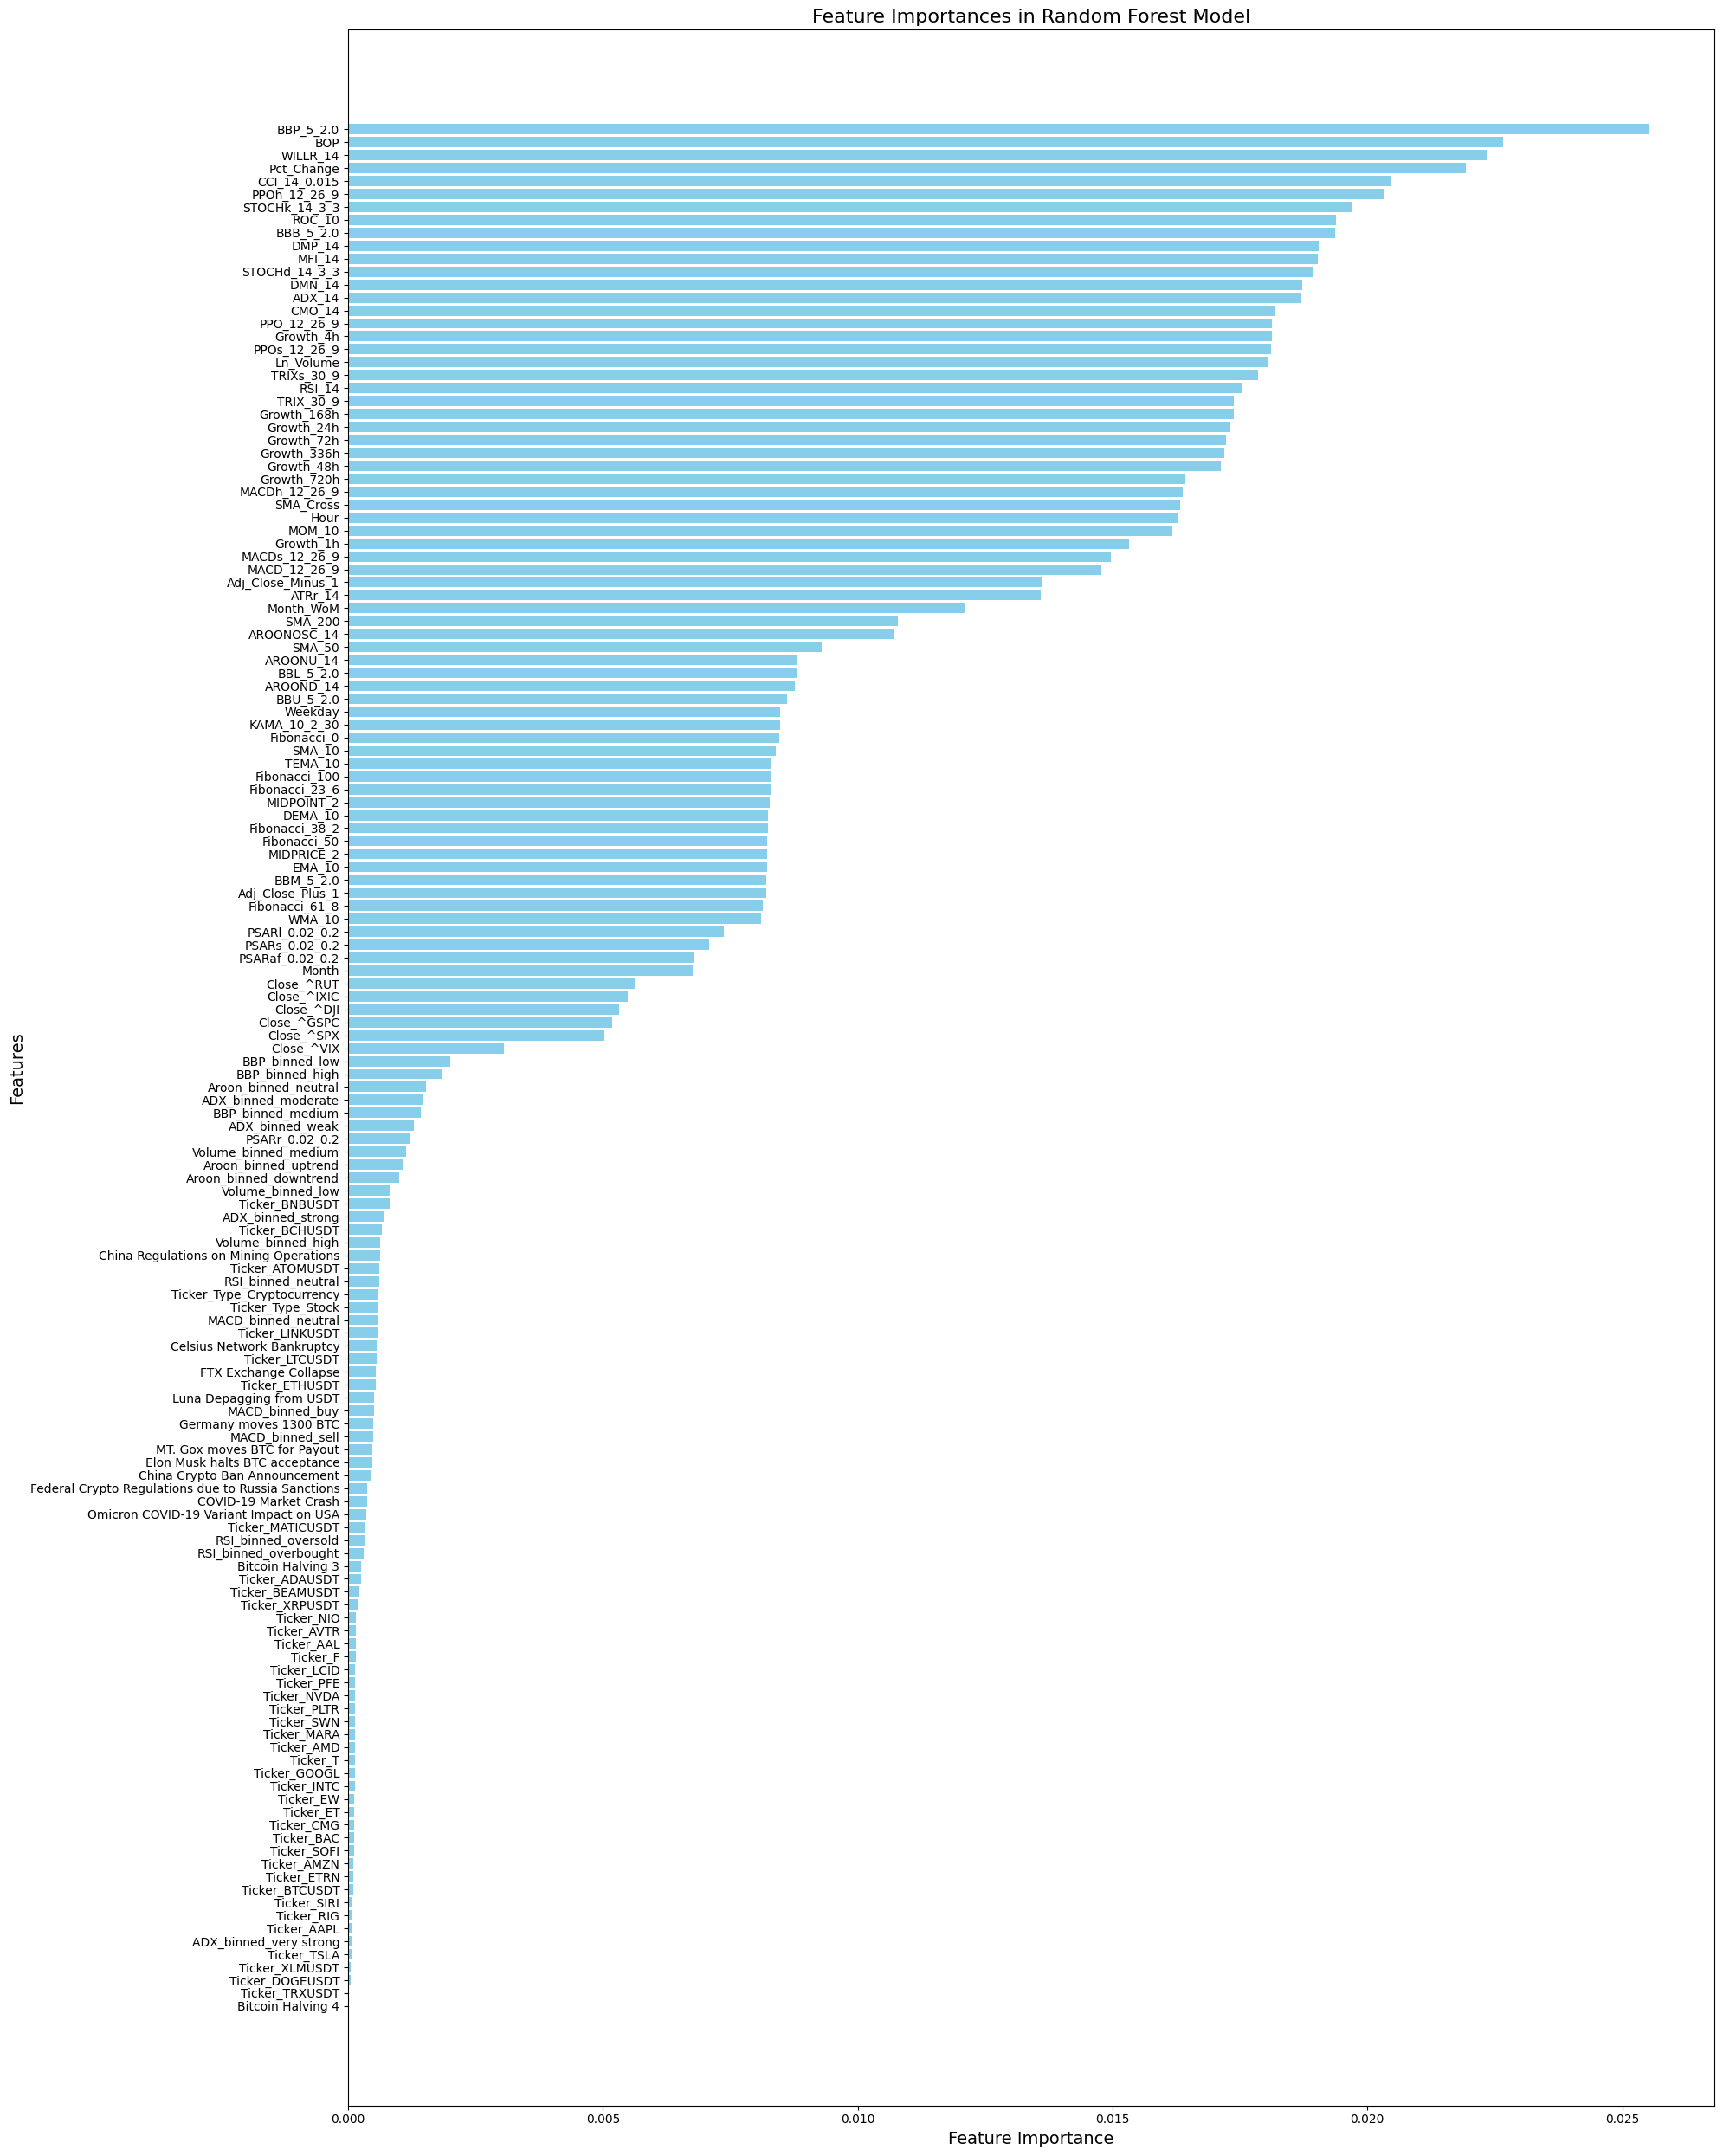

In [ ]:
# training Random Forest with best hyperparam
best_max_depth = 17
best_n_estimators = 500
rf_model = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators, random_state=42)
rf_model.fit(X_train, y_train)

# feature importances extracting
feature_importances = rf_model.feature_importances_

# convert DataFrame
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# sort importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# visualisation
plt.figure(figsize=(20, 25))

plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importances in Random Forest Model', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()


In [ ]:
# all features no treshhold
y_pred_all = rf_model.predict(X_all)

In [ ]:
# all features no treshhold
new_df['pred12_rf'] = y_pred_all

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred01_momentum_positive', 'pred02_momentum_negative', 'pred03_roc_positive', 'pred04_roc_negative', 'pred05_cci_overbought', 'pred06_cci_oversold', 'pred07_fibonacci_50_support', 'pred08_rsi_above_ma', 'pred09_macd_hist_positive', 'pred10_clf_10', 'pred11_clf_best', 'pred12_rf']
Created columns is_correct: ['is_correct_pred01', 'is_correct_pred02', 'is_correct_pred03', 'is_correct_pred04', 'is_correct_pred05', 'is_correct_pred06', 'is_correct_pred07', 'is_correct_pred08', 'is_correct_pred09', 'is_correct_pred10', 'is_correct_pred11', 'is_correct_pred12']
Precision on TEST set for each prediction:
Prediction column:pred01_momentum_positive , is_correct_column: is_correct_pred01
is_correct_pred01
0    18388
1    17715
Name: count, dtype: int64
is_correct_pred01
0    0.509321
1    0.490679
Name: count, dtype: float64
---------
Prediction column:pred02_momentum_negative , is_correct_column: is_correct_pred02
is_correct_pred02
1    16510
0    15631
Name: count

In [ ]:
# feature reduction
# treshhold for feature importance
importance_threshold = 0.005

# identify important features
important_features = features_df[features_df['Importance'] > importance_threshold]['Feature']

# reducing data
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# traing model with reduced features
rf_model_reduced = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators, random_state=42)
rf_model_reduced.fit(X_train_reduced, y_train)

# new predictions
y_pred = rf_model_reduced.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print(f'New model accuracy: {accuracy}')


New model accuracy: 0.5213272217680719


In [ ]:
# Reducing X_all to important features
X_all_reduced = X_all[important_features]

#reduced treshhold
y_pred_all = rf_model_reduced.predict(X_all_reduced)
new_df['pred13_rf_reduced'] = y_pred_all

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred01_momentum_positive', 'pred02_momentum_negative', 'pred03_roc_positive', 'pred04_roc_negative', 'pred05_cci_overbought', 'pred06_cci_oversold', 'pred07_fibonacci_50_support', 'pred08_rsi_above_ma', 'pred09_macd_hist_positive', 'pred10_clf_10', 'pred11_clf_best', 'pred12_rf', 'pred13_rf_reduced']
Created columns is_correct: ['is_correct_pred01', 'is_correct_pred02', 'is_correct_pred03', 'is_correct_pred04', 'is_correct_pred05', 'is_correct_pred06', 'is_correct_pred07', 'is_correct_pred08', 'is_correct_pred09', 'is_correct_pred10', 'is_correct_pred11', 'is_correct_pred12', 'is_correct_pred13']
Precision on TEST set for each prediction:
Prediction column:pred01_momentum_positive , is_correct_column: is_correct_pred01
is_correct_pred01
0    18388
1    17715
Name: count, dtype: int64
is_correct_pred01
0    0.509321
1    0.490679
Name: count, dtype: float64
---------
Prediction column:pred02_momentum_negative , is_correct_column: is_correct_pred02
is_correc

In [ ]:
# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[15, 20])

# Show the figure
fig.show()

## 2.4 Logistic Regression

In [ ]:
#Hyperparameter tunning
precision_matrix = {}
best_precision = 0
best_C = 0
best_iter = 0

for c in [1, 0.1, 0.01]:
    for iter in [50, 100, 200]:
        print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
        # Fitting the Tree on X_train, y_train
        # HyperParam C should be between 0 and 1
        lr = LogisticRegression(C=c,
                                random_state=42,
                                max_iter=iter,
                                solver='sag',
                                n_jobs=-1)

        lr = lr.fit(X_train_valid, y_train_valid)

        # Getting Predictions for TEST and Accuracy Acore
        y_pred_valid = lr.predict(X_valid)
        precision_valid = precision_score(y_valid, y_pred_valid)
        y_pred_test = lr.predict(X_test)
        precision_test = precision_score(y_test, y_pred_test)
        print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
        # Saving to Dict
        precision_matrix[(c, iter)] = round(precision_test, 4)
        # Updating the best Precision
        if precision_test >= best_precision:
            best_precision = round(precision_test, 4)
            best_C = c
            best_iter = iter
            print(f'New best precision found for C={c}')
            print('------------------------------')

print(f'Matrix of precisions: {precision_matrix}')
print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}')


Working with HyperParams: C = 1 (positive float, smaller = stronger regularization), max_iter=50


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.5608482871125612, (precision on valid is 0.5458122186900003 - tend to overfit)
New best precision found for C=1
------------------------------
Working with HyperParams: C = 1 (positive float, smaller = stronger regularization), max_iter=100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.5697908793146889, (precision on valid is 0.5540498731514139 - tend to overfit)
New best precision found for C=1
------------------------------
Working with HyperParams: C = 1 (positive float, smaller = stronger regularization), max_iter=200


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.5808743169398907, (precision on valid is 0.5634353636755558 - tend to overfit)
New best precision found for C=1
------------------------------
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=50


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.5608482871125612, (precision on valid is 0.5458122186900003 - tend to overfit)
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.5697908793146889, (precision on valid is 0.5540498731514139 - tend to overfit)
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=200


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.5808743169398907, (precision on valid is 0.5634353636755558 - tend to overfit)
Working with HyperParams: C = 0.01 (positive float, smaller = stronger regularization), max_iter=50


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.5608482871125612, (precision on valid is 0.5458122186900003 - tend to overfit)
Working with HyperParams: C = 0.01 (positive float, smaller = stronger regularization), max_iter=100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.5697908793146889, (precision on valid is 0.5540498731514139 - tend to overfit)
Working with HyperParams: C = 0.01 (positive float, smaller = stronger regularization), max_iter=200
  Precision on test is 0.5808743169398907, (precision on valid is 0.5634353636755558 - tend to overfit)
Matrix of precisions: {(1, 50): 0.5608, (1, 100): 0.5698, (1, 200): 0.5809, (0.1, 50): 0.5608, (0.1, 100): 0.5698, (0.1, 200): 0.5809, (0.01, 50): 0.5608, (0.01, 100): 0.5698, (0.01, 200): 0.5809}
The best precision is 0.5809 and the best C is 1, best max_iter = 200


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [ ]:
# Matrix of precisions: {(1, 50): 0.5608, (1, 100): 0.5698, (1, 200): 0.5809, (0.1, 50): 0.5608, (0.1, 100): 0.5698, (0.1, 200): 0.5809, (0.01, 50): 0.5608, (0.01, 100): 0.5698, (0.01, 200): 0.5809}
# The best precision is 0.5809 and the best C is 1, best max_iter = 200

best_precision_matrix_logistic_regression = {(1, 50): 0.5608, (1, 100): 0.5698, (1, 200): 0.5809, (0.1, 50): 0.5608, (0.1, 100): 0.5698, (0.1, 200): 0.5809, (0.01, 50): 0.5608, (0.01, 100): 0.5698, (0.01, 200): 0.5809}


In [ ]:
# Beste Hyperparameter aus dem Hypertuning
best_C = 1
best_max_iter = 200

# Modell mit den besten Hyperparametern erstellen
best_lr = make_pipeline(RobustScaler(), LogisticRegression(C=best_C, max_iter=best_max_iter, solver='liblinear'))

# Modell trainieren
best_lr.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=200, solver='liblinear'))])

In [ ]:
y_pred_all = best_lr.predict(X_all)
new_df['pred14_lr'] = y_pred_all

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred01_momentum_positive', 'pred02_momentum_negative', 'pred03_roc_positive', 'pred04_roc_negative', 'pred05_cci_overbought', 'pred06_cci_oversold', 'pred07_fibonacci_50_support', 'pred08_rsi_above_ma', 'pred09_macd_hist_positive', 'pred10_clf_10', 'pred11_clf_best', 'pred12_rf', 'pred13_rf_reduced', 'pred14_lr']
Created columns is_correct: ['is_correct_pred01', 'is_correct_pred02', 'is_correct_pred03', 'is_correct_pred04', 'is_correct_pred05', 'is_correct_pred06', 'is_correct_pred07', 'is_correct_pred08', 'is_correct_pred09', 'is_correct_pred10', 'is_correct_pred11', 'is_correct_pred12', 'is_correct_pred13', 'is_correct_pred14']
Precision on TEST set for each prediction:
Prediction column:pred01_momentum_positive , is_correct_column: is_correct_pred01
is_correct_pred01
0    18388
1    17715
Name: count, dtype: int64
is_correct_pred01
0    0.509321
1    0.490679
Name: count, dtype: float64
---------
Prediction column:pred02_momentum_negative , is_correct_c

In [ ]:
# Visualise Precision Scores

# Prepare Data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create Bar Chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize Layout for better Readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update Text Position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show Figure
fig.show()

# 3. Different Decision Rules to improve Precision

## 3.1 Predict Probalility

### 3.1.1 Logistic Regression

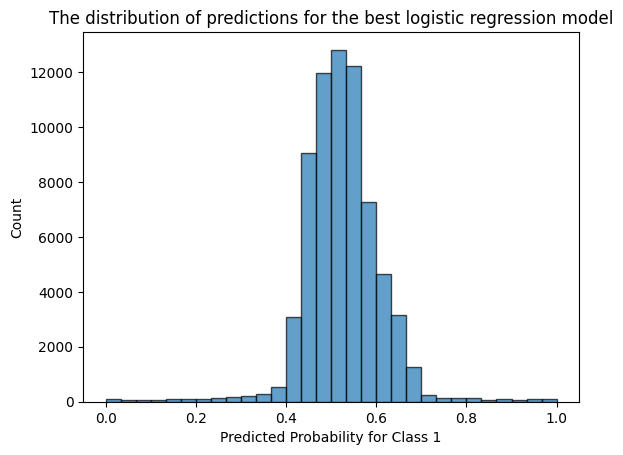

In [ ]:
# Predict Probability
y_pred_test = best_lr.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test]

# Plot
plt.hist(y_pred_test_class1, bins=30, edgecolor='k', alpha=0.7)
plt.title("The distribution of predictions for the best logistic regression model")
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Count")
plt.show()

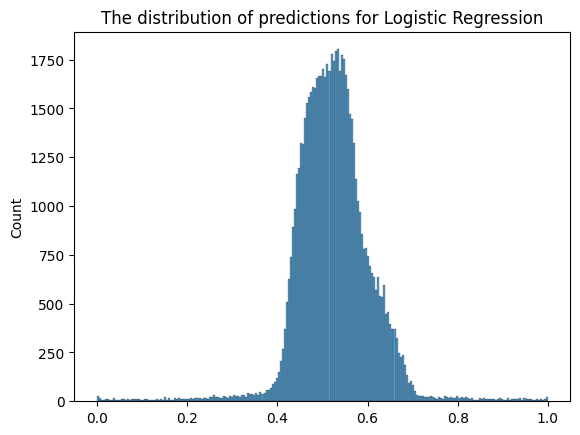

In [ ]:
sns.histplot(y_pred_test_class1)

# Add title
plt.title('The distribution of predictions for Logistic Regression')

# Show plot
plt.show()

In [ ]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [ ]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [ ]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
1,0.02,34353,34094,0,57,0.501892,1.000000,0.502306,0.668346,1.000000,0.998331
2,0.04,34353,34044,0,107,0.502259,1.000000,0.503036,0.668672,1.000000,0.996867
3,0.06,34353,34014,0,137,0.502479,1.000000,0.503474,0.668867,1.000000,0.995988
4,0.08,34353,33971,0,180,0.502796,1.000000,0.504102,0.669147,1.000000,0.994729
5,0.10,34353,33933,0,218,0.503075,1.000000,0.504657,0.669395,1.000000,0.993617
6,0.12,34353,33890,0,261,0.503392,1.000000,0.505284,0.669675,1.000000,0.992357
7,0.14,34353,33851,0,300,0.503680,1.000000,0.505854,0.669930,1.000000,0.991215
8,0.16,34353,33791,0,360,0.504124,1.000000,0.506730,0.670322,1.000000,0.989459
9,0.18,34353,33744,0,407,0.504472,1.000000,0.507416,0.670630,1.000000,0.988082


In [ ]:
df_scores[(df_scores.threshold>=0.20) & (df_scores.threshold<=0.30)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
10,0.20,34353,33816,0,335,0.503939,1.000000,0.506365,0.670159,1.000000,0.990191
11,0.22,34353,33765,0,386,0.504316,1.000000,0.507109,0.670492,1.000000,0.988697
12,0.24,34353,33703,0,448,0.504775,1.000000,0.508014,0.670898,1.000000,0.986882
13,0.26,34351,33643,2,508,0.505206,0.999942,0.508861,0.671265,0.999942,0.985125
14,0.28,34349,33557,4,594,0.505832,0.999884,0.510087,0.671804,0.999884,0.982607
15,0.30,34347,33457,6,694,0.506563,0.999825,0.511518,0.672436,0.999825,0.979678


### 3.1.2 Decision Tree

In [ ]:
# predicting probability
y_pred_test = clf_best.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

In [ ]:
# Unconditional probability of a positive growth is 51.6%
y_test.sum()/y_test.count()

0.5163932033165947

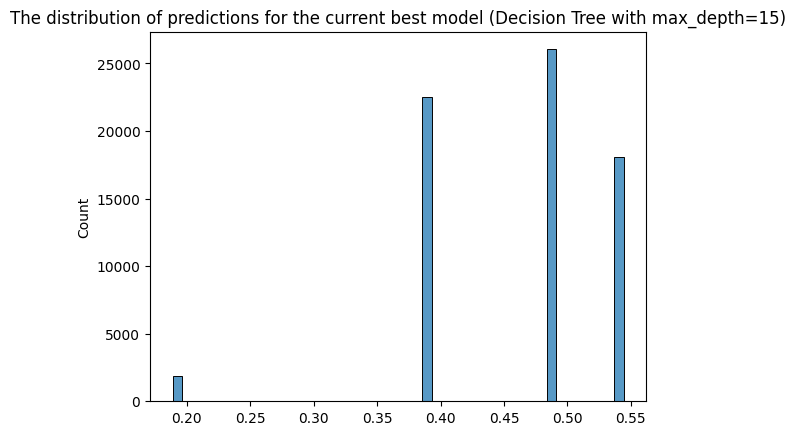

In [ ]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title('The distribution of predictions for the current model (Decision Tree with max_depth=15)')

# Show the plot
plt.show()

<Axes: title={'center': 'Precision vs. Recall for the Best Model'}, xlabel='threshold'>

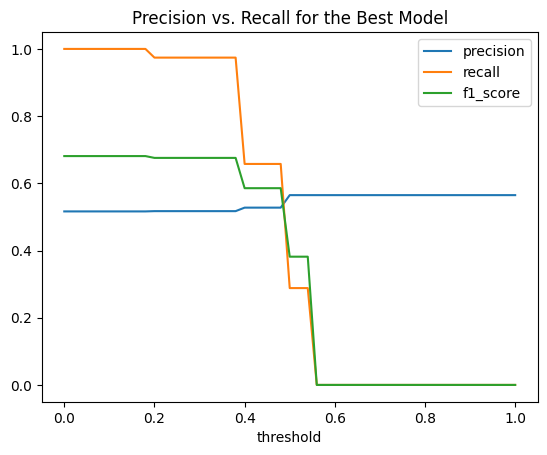

In [ ]:
# Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model')

### 3.1.3 Random Forest

In [ ]:
# predicting probability
y_pred_test = rf_model.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test]  # k[1] is the second element in the list of Class predictions

In [ ]:
# example prediction of probabilities
y_pred_test

array([[0.57310857, 0.42689143],
       [0.46878778, 0.53121222],
       [0.50944924, 0.49055076],
       ...,
       [0.45979147, 0.54020853],
       [0.5434431 , 0.4565569 ],
       [0.55389411, 0.44610589]])

In [ ]:
#without reduction
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])
y_pred_test_class1_df.head()

,Class1_probability
0,0.426891
1,0.531212
2,0.490551
3,0.495392
4,0.500639


In [ ]:
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,68504.0,0.477803,0.05204,0.281447,0.442363,0.477146,0.513136,0.746887


In [ ]:
# Unconditional probability of a positive growth is 50.1% with reduction
y_test.sum()/y_test.count()

0.5014743664603527

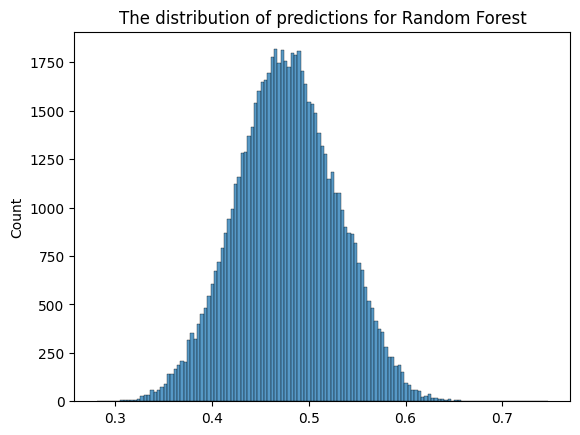

In [ ]:
sns.histplot(y_pred_test_class1)

# Add title
plt.title('The distribution of predictions for Random Forest')

# Show plot
plt.show()

In [ ]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [ ]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [ ]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
1,0.02,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
2,0.04,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
3,0.06,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
4,0.08,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
5,0.10,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
6,0.12,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
7,0.14,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
8,0.16,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000
9,0.18,34353,34151,0,0,0.501474,1.000000,0.501474,0.667976,1.000000,1.000000


In [ ]:
df_scores[(df_scores.threshold>=0.32) & (df_scores.threshold<=0.50)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
16,0.32,34303,34108,50,43,0.501425,0.998545,0.501372,0.667607,0.998545,0.998741
17,0.34,34123,33929,230,222,0.501425,0.993305,0.501358,0.666432,0.993305,0.993499
18,0.36,33709,33469,644,682,0.501786,0.981253,0.502029,0.664014,0.981253,0.980030
19,0.38,32913,32609,1440,1542,0.502320,0.958082,0.502963,0.659084,0.958082,0.954848
20,0.40,31658,31251,2695,2900,0.503235,0.921550,0.504467,0.650984,0.921550,0.915083
21,0.42,29581,28928,4772,5223,0.505580,0.861089,0.508058,0.637096,0.861089,0.847062
22,0.44,26113,25207,8240,8944,0.508827,0.760137,0.511751,0.609597,0.760137,0.738104
23,0.46,21672,20379,12681,13772,0.515374,0.630862,0.517400,0.567300,0.630862,0.596732
24,0.48,16443,14934,17910,19217,0.524046,0.478648,0.520554,0.500319,0.478648,0.437293
25,0.50,11516,9972,22837,24179,0.535927,0.335225,0.521064,0.412457,0.335225,0.291997


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

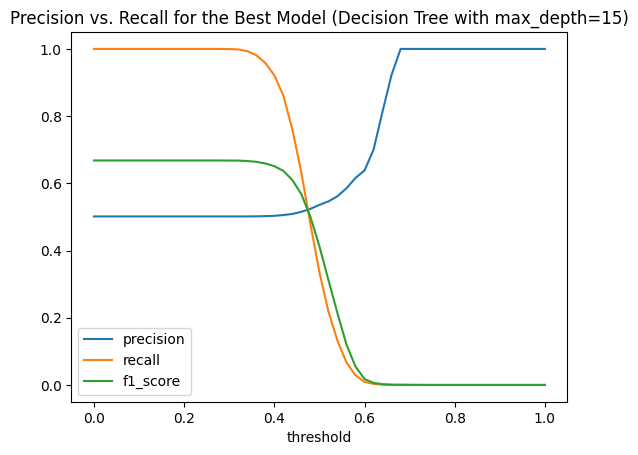

In [ ]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 3.2 Defining new columns with Predictions in new_df

In [ ]:
# adding Random Forest predictors to the dataset for new rules: Threshold = 0.32 and 0.50

y_pred_all = rf_model.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

new_df['proba_pred15'] = y_pred_all_class1_array
new_df['pred15_rf_best_rule_32'] = (y_pred_all_class1_array >= 0.32).astype(int)

new_df['proba_pred16'] = y_pred_all_class1_array
new_df['pred16_rf_best_rule_35'] = (y_pred_all_class1_array >= 0.35).astype(int)

new_df['proba_pred17'] = y_pred_all_class1_array
new_df['pred17_rf_best_rule_37'] = (y_pred_all_class1_array >= 0.37).astype(int)

new_df['proba_pred18'] = y_pred_all_class1_array
new_df['pred18_rf_best_rule_39'] = (y_pred_all_class1_array >= 0.39).astype(int)

new_df['proba_pred19'] = y_pred_all_class1_array
new_df['pred19_rf_best_rule_41'] = (y_pred_all_class1_array >= 0.41).astype(int)

new_df['proba_pred20'] = y_pred_all_class1_array
new_df['pred20_rf_best_rule_43'] = (y_pred_all_class1_array >= 0.43).astype(int)

new_df['proba_pred21'] = y_pred_all_class1_array
new_df['pred21_rf_best_rule_45'] = (y_pred_all_class1_array >= 0.45).astype(int)

new_df['proba_pred22'] = y_pred_all_class1_array
new_df['pred22_rf_best_rule_47'] = (y_pred_all_class1_array >= 0.47).astype(int)

new_df['proba_pred23'] = y_pred_all_class1_array
new_df['pred23_rf_best_rule_49'] = (y_pred_all_class1_array >= 0.49).astype(int)

new_df['proba_pred24'] = y_pred_all_class1_array
new_df['pred24_rf_best_rule_50'] = (y_pred_all_class1_array >= 0.50).astype(int) # best one


In [ ]:
# adding Logistic Regression

y_pred_all = best_lr.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all]
y_pred_all_class1_array = np.array(y_pred_all_class1)

new_df['proba_pred25'] = y_pred_all_class1_array
new_df['pred25_lr_best_rule_25'] = (y_pred_all_class1_array >= 0.25).astype(int)

new_df['proba_pred26'] = y_pred_all_class1_array
new_df['pred26_lr_best_rule_26'] = (y_pred_all_class1_array >= 0.26).astype(int)

new_df['proba_pred27'] = y_pred_all_class1_array
new_df['pred27_lr_best_rule_27'] = (y_pred_all_class1_array >= 0.27).astype(int)

new_df['proba_pred28'] = y_pred_all_class1_array
new_df['pred28_lr_best_rule_28'] = (y_pred_all_class1_array >= 0.28).astype(int)

new_df['proba_pred29'] = y_pred_all_class1_array
new_df['pred29_lr_best_rule_30'] = (y_pred_all_class1_array >= 0.30).astype(int)

new_df['proba_pred30'] = y_pred_all_class1_array
new_df['pred30_lr_best_rule_50'] = (y_pred_all_class1_array >= 0.50).astype(int)

## 3.3 Aggregated Stats an all perdictions


In [ ]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='Is_Positive_Growth_1h_Future')

Prediction columns founded: ['pred01_momentum_positive', 'pred02_momentum_negative', 'pred03_roc_positive', 'pred04_roc_negative', 'pred05_cci_overbought', 'pred06_cci_oversold', 'pred07_fibonacci_50_support', 'pred08_rsi_above_ma', 'pred09_macd_hist_positive', 'pred10_clf_10', 'pred11_clf_best', 'pred12_rf', 'pred13_rf_reduced', 'pred14_lr', 'pred15_rf_best_rule_32', 'pred16_rf_best_rule_35', 'pred17_rf_best_rule_37', 'pred18_rf_best_rule_39', 'pred19_rf_best_rule_41', 'pred20_rf_best_rule_43', 'pred21_rf_best_rule_45', 'pred22_rf_best_rule_47', 'pred23_rf_best_rule_49', 'pred24_rf_best_rule_50', 'pred25_lr_best_rule_25', 'pred26_lr_best_rule_26', 'pred27_lr_best_rule_27', 'pred28_lr_best_rule_28', 'pred29_lr_best_rule_30', 'pred30_lr_best_rule_50']
Created columns is_correct: ['is_correct_pred01', 'is_correct_pred02', 'is_correct_pred03', 'is_correct_pred04', 'is_correct_pred05', 'is_correct_pred06', 'is_correct_pred07', 'is_correct_pred08', 'is_correct_pred09', 'is_correct_pred10', 

In [ ]:
PREDICTIONS

['pred01_momentum_positive',
 'pred02_momentum_negative',
 'pred03_roc_positive',
 'pred04_roc_negative',
 'pred05_cci_overbought',
 'pred06_cci_oversold',
 'pred07_fibonacci_50_support',
 'pred08_rsi_above_ma',
 'pred09_macd_hist_positive',
 'pred10_clf_10',
 'pred11_clf_best',
 'pred13_rf_reduced',
 'pred14_lr',
 'pred15_rf_best_rule_32',
 'pred16_rf_best_rule_35',
 'pred17_rf_best_rule_37',
 'pred18_rf_best_rule_39',
 'pred19_rf_best_rule_41',
 'pred20_rf_best_rule_43',
 'pred21_rf_best_rule_45',
 'pred22_rf_best_rule_47',
 'pred23_rf_best_rule_49',
 'pred24_rf_best_rule_50',
 'pred25_lr_best_rule_25',
 'pred26_lr_best_rule_26',
 'pred27_lr_best_rule_27',
 'pred28_lr_best_rule_28',
 'pred29_lr_best_rule_30',
 'pred30_lr_best_rule_50']

<Axes: >

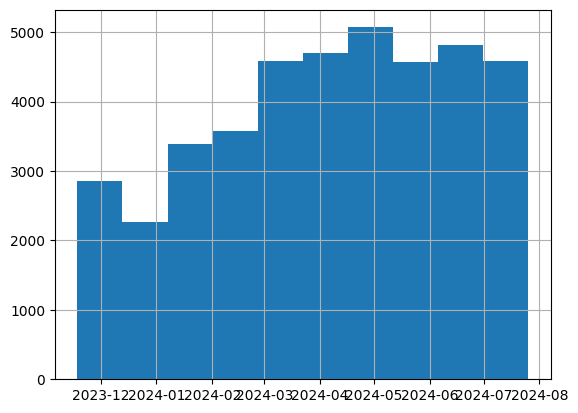

In [ ]:
# best one
new_df[(new_df.Split=='Test')&(new_df.pred14_lr==1)].Date.hist()

<Axes: >

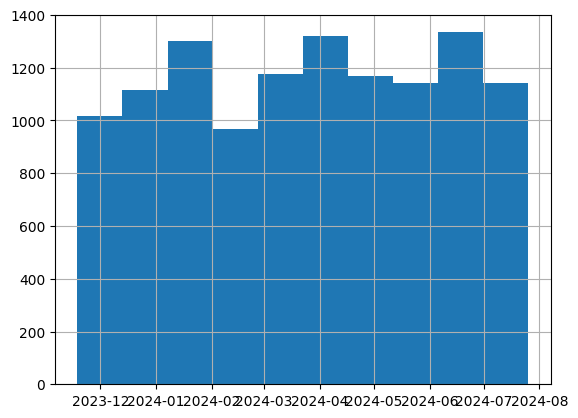

In [ ]:
# another strong one
new_df[(new_df.Split=='Test')&(new_df.pred06_cci_oversold==1)].Date.hist()

In [ ]:
# Pred 14: How many positive prediction per day
pred14_daily_positive_count = pd.DataFrame(new_df[(new_df.Split=='Test')&(new_df.pred14_lr==1)].groupby('Date')['pred14_lr'].count())

In [ ]:
# Pred 06: How many positive prediction per day
pred06_daily_positive_count = pd.DataFrame(new_df[(new_df.Split=='Test')&(new_df.pred06_cci_oversold==1)].groupby('Date')['pred06_cci_oversold'].count())

In [ ]:
# Unique trading days on Test
new_df[(new_df.Split=='Test')].Date.nunique()

7172

In [ ]:
pred14_daily_positive_count

,pred14_lr
Date,
2023-11-18 01:00:00+01:00,6
2023-11-18 02:00:00+01:00,5
2023-11-18 03:00:00+01:00,4
2023-11-18 04:00:00+01:00,7
2023-11-18 05:00:00+01:00,3
...,...
2024-07-25 17:30:00+02:00,13
2024-07-25 18:30:00+02:00,19
2024-07-25 19:30:00+02:00,22


array([[<Axes: title={'center': 'pred14_lr'}>]], dtype=object)

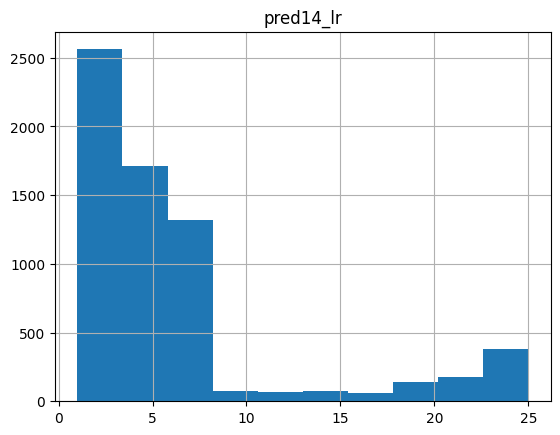

In [ ]:
pred14_daily_positive_count.hist()

In [ ]:
# 75% cases we have not more than 6 bets of $100
pred14_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred14_lr,6573.0,6.147573,6.212445,1.0,2.0,4.0,6.0,25.0


The statistics for predictions with a threshold of 0.47 show an average of about 5 positive predictions per day, with values ranging from 1 to 20. Most days have between 4 and 7 positive predictions, indicating moderate variability in daily prediction counts.

array([[<Axes: title={'center': 'pred06_cci_oversold'}>]], dtype=object)

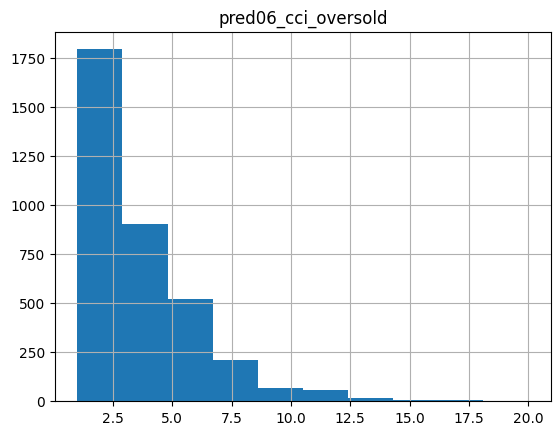

In [ ]:
pred06_daily_positive_count.hist()

In [ ]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred05_cci_overbought',
 'pred06_cci_oversold',
 'pred07_fibonacci_50_support',
 'pred08_rsi_above_ma',
 'pred09_macd_hist_positive',
 'pred10_clf_10',
 'pred11_clf_best',
 'pred12_rf',
 'pred13_rf_reduced',
 'pred14_lr',
 'pred15_rf_best_rule_32',
 'pred16_rf_best_rule_35',
 'pred17_rf_best_rule_37',
 'pred18_rf_best_rule_39',
 'pred19_rf_best_rule_41',
 'pred20_rf_best_rule_43',
 'pred21_rf_best_rule_45',
 'pred22_rf_best_rule_47',
 'pred23_rf_best_rule_49',
 'pred24_rf_best_rule_50',
 'pred25_lr_best_rule_25',
 'pred26_lr_best_rule_26',
 'pred27_lr_best_rule_27',
 'pred28_lr_best_rule_28',
 'pred29_lr_best_rule_30',
 'pred30_lr_best_rule_50']

In [ ]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred05',
 'is_correct_pred06',
 'is_correct_pred07',
 'is_correct_pred08',
 'is_correct_pred09',
 'is_correct_pred10',
 'is_correct_pred11',
 'is_correct_pred12',
 'is_correct_pred13',
 'is_correct_pred14',
 'is_correct_pred15',
 'is_correct_pred16',
 'is_correct_pred17',
 'is_correct_pred18',
 'is_correct_pred19',
 'is_correct_pred20',
 'is_correct_pred21',
 'is_correct_pred22',
 'is_correct_pred23',
 'is_correct_pred24',
 'is_correct_pred25',
 'is_correct_pred26',
 'is_correct_pred27',
 'is_correct_pred28',
 'is_correct_pred29',
 'is_correct_pred30']

In [ ]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('Split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

Split                                 Test          Train    Validation
pred05_cci_overbought  count  68504.000000  227696.000000  68385.000000
                       sum    14787.000000   48265.000000  14163.000000
                       mean       0.215856       0.211971      0.207107
pred06_cci_oversold    count  68504.000000  227696.000000  68385.000000
                       sum    11676.000000   40173.000000  11629.000000
...                                    ...            ...           ...
pred29_lr_best_rule_30 sum    67619.000000  224710.000000  68217.000000
                       mean       0.987081       0.986886      0.997543
pred30_lr_best_rule_50 count  68504.000000  227696.000000  68385.000000
                       sum    42500.000000  110983.000000  38593.000000
                       mean       0.620402       0.487417      0.564349

[78 rows x 3 columns]

# 4. Trading Simulations

## 4.1 Investing $150 on every positive prediction    

fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

In [ ]:
pred = 'pred14_lr'

In [ ]:
# Total Number of Investment Opportunities
new_df[new_df.Split=='Test'].Close.count()

68504

In [ ]:
# Total Number of Days
new_df[new_df.Split=='Test'].Date.nunique()

7172

In [ ]:
# check actual future growth
TO_PREDICT

['Growth_Future_1h',
 'Is_Positive_Growth_1h_Future',
 'Growth_Future_4h',
 'Is_Positive_Growth_4h_Future',
 'Growth_Future_24h',
 'Is_Positive_Growth_24h_Future',
 'Growth_Future_48h',
 'Is_Positive_Growth_48h_Future',
 'Growth_Future_72h',
 'Is_Positive_Growth_72h_Future',
 'Growth_Future_168h',
 'Is_Positive_Growth_168h_Future',
 'Growth_Future_336h',
 'Is_Positive_Growth_336h_Future',
 'Growth_Future_720h',
 'Is_Positive_Growth_720h_Future']

In [ ]:
new_df[['Growth_Future_1h','Is_Positive_Growth_1h_Future',pred]]

,Growth_Future_1h,Is_Positive_Growth_1h_Future,pred14_lr
0,0.998047,0,0
1,0.992188,0,0
2,1.002930,1,1
3,0.997559,0,1
4,1.002930,1,1
...,...,...,...
364580,0.997559,0,1
364581,0.995605,0,1
364582,1.002930,1,1
364583,0.993652,0,1


### 4.1.1 Strategy 1

In [ ]:
# Define thresholds for stop loss and take profit
stop_loss_threshold = -0.02  # Stop loss at -2%
take_profit_threshold = 0.07  # Take profit at +7%

# Generate trade signal by combining multiple prediction models
new_df['Trade_Signal_1'] = (
    (new_df['pred11_clf_best'] == 1) &       # Model 11: Best classifier prediction
    (new_df['pred12_rf'] == 1) &             # Model 12: Random forest prediction
    (new_df['pred30_lr_best_rule_50'] == 1) & # Model 30: Logistic regression with custom rule
    (new_df['pred13_rf_reduced'] == 1) &     # Model 13: Reduced random forest prediction
    (new_df['pred09_macd_hist_positive'] == 1) & # MACD histogram is positive (bullish signal)
    (new_df['pred05_cci_overbought'] == 0)   # CCI indicates not overbought (avoiding potential reversal)
)

# Calculate gross revenue with clipping to account for stop loss and take profit limits
new_df['sim1_gross_rev_pred14'] = new_df['Trade_Signal_1'] * 150 * (
    new_df['Growth_Future_1h'].clip(lower=(1 + stop_loss_threshold), upper=(1 + take_profit_threshold)) - 1
)

# Calculate trading fees (assumed 0.2% per trade)
new_df['sim1_fees_pred14'] = new_df['Trade_Signal_1'].abs() * 0.002

# Calculate net revenue by subtracting fees from gross revenue
new_df['sim1_net_rev_pred14'] = new_df['sim1_gross_rev_pred14'] - new_df['sim1_fees_pred14']

# Output the total net revenue from all trades
print(new_df['sim1_net_rev_pred14'].sum())


15615.514906249997


In [ ]:
#show it for all predictions
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred, 'sim1_gross_rev_pred14','sim1_fees_pred14','sim1_net_rev_pred14']
new_df[(new_df.Split=='Test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT]

,Date,Ticker,Close,Growth_Future_1h,Is_Positive_Growth_1h_Future,Growth_Future_4h,Is_Positive_Growth_4h_Future,Growth_Future_24h,Is_Positive_Growth_24h_Future,Growth_Future_48h,Is_Positive_Growth_48h_Future,Growth_Future_72h,Is_Positive_Growth_72h_Future,Growth_Future_168h,Is_Positive_Growth_168h_Future,Growth_Future_336h,Is_Positive_Growth_336h_Future,Growth_Future_720h,Is_Positive_Growth_720h_Future,pred14_lr,sim1_gross_rev_pred14,sim1_fees_pred14,sim1_net_rev_pred14
32983,2023-11-18 04:00:00+01:00,BTCUSDT,36371.808594,1.000000,0,1.000977,1,1.003906,1,1.020508,1,1.030273,1,1.039062,1,1.066406,1,1.129883,1,1,0.0,0.0,0.0
32986,2023-11-18 07:00:00+01:00,BTCUSDT,36252.000000,1.004883,1,1.005859,1,1.009766,1,1.025391,1,1.031250,1,1.042969,1,1.069336,1,1.136719,1,1,0.0,0.0,0.0
32987,2023-11-18 08:00:00+01:00,BTCUSDT,36417.160156,1.000977,1,0.999512,0,1.004883,1,1.022461,1,1.023438,1,1.038086,1,1.062500,1,1.128906,1,1,0.0,0.0,0.0
32989,2023-11-18 10:00:00+01:00,BTCUSDT,36397.449219,1.001953,1,1.000977,1,1.005859,1,1.021484,1,1.025391,1,1.037109,1,1.065430,1,1.127930,1,1,0.0,0.0,0.0
32991,2023-11-18 12:00:00+01:00,BTCUSDT,36402.800781,1.000977,1,1.006836,1,1.000977,1,1.020508,1,1.021484,1,1.034180,1,1.064453,1,1.128906,1,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364580,2024-07-25 17:30:00+02:00,PFE,30.480000,0.997559,0,0.990234,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.0,0.0,-0.0
364581,2024-07-25 18:30:00+02:00,PFE,30.410101,0.995605,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.0,0.0,-0.0
364582,2024-07-25 19:30:00+02:00,PFE,30.275000,1.002930,1,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,0.0,0.0,0.0
364583,2024-07-25 20:30:00+02:00,PFE,30.375000,0.993652,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.0,0.0,-0.0


In [ ]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.Split=='Test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)
print(sim1_avg_investments_per_day)

6.0


In [ ]:
# Distribution: how many times do we trade daily (for the current Prediction)?
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred14_lr,6572.0,6.466829,6.663988,1.0,2.0,4.0,6.0,25.0


In [ ]:
new_df[(new_df.Split=='Test')&(new_df[pred]==1)][['sim1_gross_rev_pred14','sim1_fees_pred14','sim1_net_rev_pred14']].sum()

,0
sim1_gross_rev_pred14,232.790039
sim1_fees_pred14,7.250000
sim1_net_rev_pred14,225.540039


### 4.1.2 Strategy 2

In [ ]:
# Generate trade signal based on selected features (as indicated by the random forest model)

new_df['Trade_Signal_2'] = (
    (new_df['BBP_5_2.0'] > 0.7) &  # Bollinger Band Position above 0.7 (indicating price is near the upper band)
    (new_df['BOP'] > 0)  # Positive Balance of Power (indicating bullish momentum)
)

# Define thresholds for stop loss and take profit
stop_loss_threshold = -0.02  # Stop loss at -2%
take_profit_threshold = 0.07  # Take profit at +7%

# Calculate gross revenue with clipping to account for stop loss and take profit limits
new_df['sim2_gross_rev_pred14'] = new_df['Trade_Signal_2'] * 150 * (
    new_df['Growth_Future_1h'].clip(lower=(1 + stop_loss_threshold), upper=(1 + take_profit_threshold)) - 1
)

# Calculate trading fees (assumed 0.2% per trade)
new_df['sim2_fees_pred14'] = new_df['Trade_Signal_2'].abs() * 0.002

# Calculate net revenue by subtracting fees from gross revenue
new_df['sim2_net_rev_pred14'] = new_df['sim2_gross_rev_pred14'] - new_df['sim2_fees_pred14']

# Output the total net revenue from all trades
print(new_df['sim2_net_rev_pred14'].sum())


3340.357890624998


In [ ]:
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred,  'sim2_gross_rev_pred14','sim2_fees_pred14','sim2_net_rev_pred14']
new_df[(new_df.Split=='Test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT]

,Date,Ticker,Close,Growth_Future_1h,Is_Positive_Growth_1h_Future,Growth_Future_4h,Is_Positive_Growth_4h_Future,Growth_Future_24h,Is_Positive_Growth_24h_Future,Growth_Future_48h,Is_Positive_Growth_48h_Future,Growth_Future_72h,Is_Positive_Growth_72h_Future,Growth_Future_168h,Is_Positive_Growth_168h_Future,Growth_Future_336h,Is_Positive_Growth_336h_Future,Growth_Future_720h,Is_Positive_Growth_720h_Future,pred14_lr,sim2_gross_rev_pred14,sim2_fees_pred14,sim2_net_rev_pred14
32983,2023-11-18 04:00:00+01:00,BTCUSDT,36371.808594,1.000000,0,1.000977,1,1.003906,1,1.020508,1,1.030273,1,1.039062,1,1.066406,1,1.129883,1,1,0.000000,0.000,0.000000
32986,2023-11-18 07:00:00+01:00,BTCUSDT,36252.000000,1.004883,1,1.005859,1,1.009766,1,1.025391,1,1.031250,1,1.042969,1,1.069336,1,1.136719,1,1,0.000000,0.000,0.000000
32987,2023-11-18 08:00:00+01:00,BTCUSDT,36417.160156,1.000977,1,0.999512,0,1.004883,1,1.022461,1,1.023438,1,1.038086,1,1.062500,1,1.128906,1,1,0.146484,0.002,0.144484
32989,2023-11-18 10:00:00+01:00,BTCUSDT,36397.449219,1.001953,1,1.000977,1,1.005859,1,1.021484,1,1.025391,1,1.037109,1,1.065430,1,1.127930,1,1,0.000000,0.000,0.000000
32991,2023-11-18 12:00:00+01:00,BTCUSDT,36402.800781,1.000977,1,1.006836,1,1.000977,1,1.020508,1,1.021484,1,1.034180,1,1.064453,1,1.128906,1,1,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364580,2024-07-25 17:30:00+02:00,PFE,30.480000,0.997559,0,0.990234,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.000000,0.000,-0.000000
364581,2024-07-25 18:30:00+02:00,PFE,30.410101,0.995605,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.000000,0.000,-0.000000
364582,2024-07-25 19:30:00+02:00,PFE,30.275000,1.002930,1,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,0.000000,0.000,0.000000
364583,2024-07-25 20:30:00+02:00,PFE,30.375000,0.993652,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.000000,0.000,-0.000000


In [ ]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.Split=='Test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim2_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)
print(sim2_avg_investments_per_day)

6.0


In [ ]:
new_df[(new_df.Split=='Test')&(new_df[pred]==1)][['sim2_gross_rev_pred14','sim2_fees_pred14','sim2_net_rev_pred14']].sum()

,0
sim2_gross_rev_pred14,891.345703
sim2_fees_pred14,11.300000
sim2_net_rev_pred14,880.045703


### 4.1.3 Strategy 3

In [ ]:
# Volatility strategy using ATR and Bollinger Bands

stop_loss_threshold = -0.02  # 2% Stop-Loss
take_profit_threshold = 0.07  # 7% Take-Profit

# Generate trade signal based on volatility and Bollinger Bands
new_df['Trade_Signal_3'] = (
    (new_df['ATRr_14'] > 0.015) &  # High volatility indicated by ATR
    (new_df['BBP_5_2.0'] < 0.2)    # Price near the lower Bollinger Band (potentially oversold)
)

# Calculate gross revenue with stop-loss and take-profit limits applied
new_df['sim3_gross_rev_pred14'] = new_df['Trade_Signal_3'] * 150 * (
    new_df['Growth_4h'].clip(lower=(1 + stop_loss_threshold), upper=(1 + take_profit_threshold)) - 1
)

# Calculate trading fees (assumed 0.2% per trade)
new_df['sim3_fees_pred14'] = new_df['Trade_Signal_3'].abs() * 0.002

# Calculate net revenue by subtracting fees from gross revenue
new_df['sim3_net_rev_pred14'] = new_df['sim3_gross_rev_pred14'] - new_df['sim3_fees_pred14']

# Output the total net revenue from all trades
print(new_df['sim3_net_rev_pred14'].sum())


164898.69578125002


In [ ]:
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred, 'sim3_gross_rev_pred14','sim3_fees_pred14','sim3_net_rev_pred14']
new_df[(new_df.Split=='Test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT]

,Date,Ticker,Close,Growth_Future_1h,Is_Positive_Growth_1h_Future,Growth_Future_4h,Is_Positive_Growth_4h_Future,Growth_Future_24h,Is_Positive_Growth_24h_Future,Growth_Future_48h,Is_Positive_Growth_48h_Future,Growth_Future_72h,Is_Positive_Growth_72h_Future,Growth_Future_168h,Is_Positive_Growth_168h_Future,Growth_Future_336h,Is_Positive_Growth_336h_Future,Growth_Future_720h,Is_Positive_Growth_720h_Future,pred14_lr,sim3_gross_rev_pred14,sim3_fees_pred14,sim3_net_rev_pred14
32983,2023-11-18 04:00:00+01:00,BTCUSDT,36371.808594,1.000000,0,1.000977,1,1.003906,1,1.020508,1,1.030273,1,1.039062,1,1.066406,1,1.129883,1,1,0.000000,0.000,0.000000
32986,2023-11-18 07:00:00+01:00,BTCUSDT,36252.000000,1.004883,1,1.005859,1,1.009766,1,1.025391,1,1.031250,1,1.042969,1,1.069336,1,1.136719,1,1,0.585938,0.000,0.585938
32987,2023-11-18 08:00:00+01:00,BTCUSDT,36417.160156,1.000977,1,0.999512,0,1.004883,1,1.022461,1,1.023438,1,1.038086,1,1.062500,1,1.128906,1,1,-0.000000,0.002,-0.002000
32989,2023-11-18 10:00:00+01:00,BTCUSDT,36397.449219,1.001953,1,1.000977,1,1.005859,1,1.021484,1,1.025391,1,1.037109,1,1.065430,1,1.127930,1,1,-0.000000,0.000,-0.000000
32991,2023-11-18 12:00:00+01:00,BTCUSDT,36402.800781,1.000977,1,1.006836,1,1.000977,1,1.020508,1,1.021484,1,1.034180,1,1.064453,1,1.128906,1,1,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364580,2024-07-25 17:30:00+02:00,PFE,30.480000,0.997559,0,0.990234,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.000000,0.000,-0.000000
364581,2024-07-25 18:30:00+02:00,PFE,30.410101,0.995605,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.000000,0.000,-0.000000
364582,2024-07-25 19:30:00+02:00,PFE,30.275000,1.002930,1,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,1.904297,0.000,1.904297
364583,2024-07-25 20:30:00+02:00,PFE,30.375000,0.993652,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,0.000000,0.000,0.000000


In [ ]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.Split=='Test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim3_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim3_avg_investments_per_day)

6.0


In [ ]:
new_df[(new_df.Split=='Test')&(new_df[pred]==1)][['sim3_gross_rev_pred14','sim3_fees_pred14','sim3_net_rev_pred14']].sum()

,0
sim3_gross_rev_pred14,23989.702148
sim3_fees_pred14,11.300000
sim3_net_rev_pred14,23978.402148


### 4.1.4 Strategy 4

In [ ]:

stop_loss_threshold = -0.02  # 3% Stop-Loss
take_profit_threshold = 0.06  # 6% Take-Profit

new_df['Trade_Signal_4'] = (
    (new_df['SMA_Cross'] == 1) &  # SMA-Kreuzung als Trendwechsel
    (new_df['ADX_14'] > 25)       # Starker Trend (ADX über 25)
)

# Berechnung des Bruttogewinns mit Stop-Loss und Take-Profit
new_df['sim4_gross_rev_pred14'] = new_df['Trade_Signal_4'] * 150 * (
    new_df['Growth_24h'].clip(lower=(1 + stop_loss_threshold), upper=(1 + take_profit_threshold)) - 1
)

new_df['sim4_fees_pred14'] = new_df['Trade_Signal_4'].abs() * 0.002
new_df['sim4_net_rev_pred14'] = new_df['sim4_gross_rev_pred14'] - new_df['sim4_fees_pred14']

# print
print(new_df['sim4_net_rev_pred14'].sum())


7115.325140625004


In [ ]:
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred,  'sim4_gross_rev_pred14','sim4_fees_pred14','sim4_net_rev_pred14']
new_df[(new_df.Split=='Test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT]

,Date,Ticker,Close,Growth_Future_1h,Is_Positive_Growth_1h_Future,Growth_Future_4h,Is_Positive_Growth_4h_Future,Growth_Future_24h,Is_Positive_Growth_24h_Future,Growth_Future_48h,Is_Positive_Growth_48h_Future,Growth_Future_72h,Is_Positive_Growth_72h_Future,Growth_Future_168h,Is_Positive_Growth_168h_Future,Growth_Future_336h,Is_Positive_Growth_336h_Future,Growth_Future_720h,Is_Positive_Growth_720h_Future,pred14_lr,sim4_gross_rev_pred14,sim4_fees_pred14,sim4_net_rev_pred14
32983,2023-11-18 04:00:00+01:00,BTCUSDT,36371.808594,1.000000,0,1.000977,1,1.003906,1,1.020508,1,1.030273,1,1.039062,1,1.066406,1,1.129883,1,1,0.0,0.0,0.0
32986,2023-11-18 07:00:00+01:00,BTCUSDT,36252.000000,1.004883,1,1.005859,1,1.009766,1,1.025391,1,1.031250,1,1.042969,1,1.069336,1,1.136719,1,1,0.0,0.0,0.0
32987,2023-11-18 08:00:00+01:00,BTCUSDT,36417.160156,1.000977,1,0.999512,0,1.004883,1,1.022461,1,1.023438,1,1.038086,1,1.062500,1,1.128906,1,1,-0.0,0.0,-0.0
32989,2023-11-18 10:00:00+01:00,BTCUSDT,36397.449219,1.001953,1,1.000977,1,1.005859,1,1.021484,1,1.025391,1,1.037109,1,1.065430,1,1.127930,1,1,-0.0,0.0,-0.0
32991,2023-11-18 12:00:00+01:00,BTCUSDT,36402.800781,1.000977,1,1.006836,1,1.000977,1,1.020508,1,1.021484,1,1.034180,1,1.064453,1,1.128906,1,1,-0.0,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364580,2024-07-25 17:30:00+02:00,PFE,30.480000,0.997559,0,0.990234,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.0,0.0,-0.0
364581,2024-07-25 18:30:00+02:00,PFE,30.410101,0.995605,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.0,0.0,-0.0
364582,2024-07-25 19:30:00+02:00,PFE,30.275000,1.002930,1,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.0,0.0,-0.0
364583,2024-07-25 20:30:00+02:00,PFE,30.375000,0.993652,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,1,-0.0,0.0,-0.0


In [ ]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.Split=='Test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim4_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim4_avg_investments_per_day)

6.0


In [ ]:
new_df[(new_df.Split=='Test')&(new_df[pred]==1)][['sim4_gross_rev_pred14','sim4_fees_pred14','sim4_net_rev_pred14']].sum()

,0
sim4_gross_rev_pred14,1691.759766
sim4_fees_pred14,0.424000
sim4_net_rev_pred14,1691.335766


## 4.2 Calculate final results for all fields

In [ ]:
sim3_results = []  # initialize array

stop_loss_threshold = -0.02  # 2% stop-loss
take_profit_threshold = 0.07  # 7% take-profit

# Strategie definieren
new_df['Trade_Signal3'] = (
    (new_df['ATRr_14'] > 0.015) &  # high volatilität
    (new_df['BBP_5_2.0'] < 0.2)   # touching lower bb
)

# calculating revenue for all PREDICTIONS
for pred in PREDICTIONS:
    print(f'Calculating simulation for prediction {pred}:')

    gross_rev_column = f'sim3_gross_rev_{pred}'
    fees_column = f'sim3_fees_{pred}'
    net_rev_column = f'sim3_net_rev_{pred}'

    # for trade signal 'Trade_Signal3'
    if pred == 'Trade_Signal3':
        new_df[gross_rev_column] = new_df['Trade_Signal3'] * 150 * (
            new_df['Growth_4h'].clip(lower=(1 + stop_loss_threshold), upper=(1 + take_profit_threshold)) - 1
        )
    else:
        new_df[gross_rev_column] = new_df[pred] * 150 * (new_df['Growth_4h'] - 1)

    # calculating fees
    new_df[fees_column] = -abs(new_df[pred]) * 0.002
    new_df[net_rev_column] = new_df[gross_rev_column] + new_df[fees_column]

    # calculate results
    filter_test_and_positive_pred = (new_df.Split == 'Test') & (new_df[pred] == 1)
    sim3_count_investments = len(new_df[filter_test_and_positive_pred])
    sim3_gross_rev = new_df[filter_test_and_positive_pred][gross_rev_column].sum()
    sim3_fees = new_df[filter_test_and_positive_pred][fees_column].sum()
    sim3_net_rev = new_df[filter_test_and_positive_pred][net_rev_column].sum()

    if sim3_gross_rev > 0:
        sim3_fees_percentage = -sim3_fees / sim3_gross_rev
    else:
        sim3_fees_percentage = None

    if sim3_count_investments > 0:
        sim3_average_net_revenue = sim3_net_rev / sim3_count_investments
    else:
        sim3_average_net_revenue = None

    # capital and CAGR
    df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
    sim3_avg_investments_per_day = df_investments_count_daily[pred].mean()
    sim3_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)
    sim3_capital = 150 * 5 * sim3_q75_investments_per_day
    sim3_CAGR = ((sim3_capital + sim3_net_rev) / sim3_capital) ** (1 / 4) # -1 laut chatgpt

    # safe to array
    sim3_results.append((pred, sim3_count_investments, sim3_gross_rev, sim3_fees, sim3_net_rev, sim3_fees_percentage,
                         sim3_average_net_revenue, sim3_avg_investments_per_day, sim3_capital, sim3_CAGR))

    # print results
    if sim3_count_investments > 1:
        print(f" Financial Result: \n {new_df[filter_test_and_positive_pred][[gross_rev_column, fees_column, net_rev_column]].sum()}")
        print(f" Count Investments in 4 years (on TEST): {sim3_count_investments}")
        print(f" Gross Revenue: ${int(sim3_gross_rev)}")
        print(f" Fees (0.2% for buy+sell): ${int(-sim3_fees)}")
        print(f" Net Revenue: ${int(sim3_net_rev)}")
        print(f" Fees are {int(-10.0 * sim3_fees / sim3_gross_rev)} % from Gross Revenue")
        print(f" Capital Required : ${int(sim3_capital)} (Vbegin)")
        print(f" Final value (Vbegin + Net_revenue) : ${int(sim3_capital + sim3_net_rev)} (Vfinal)")
        print(f" Average CAGR on TEST (4 years) : {np.round(sim3_CAGR, 3)}, or {np.round(10.0 * (sim3_CAGR - 1), 1)}% ")
        print(f" Average daily stats: ")
        print(f" Average net revenue per investment: ${np.round(sim3_net_rev / sim3_count_investments, 2)} ")
        print(f" Average investments per day: {int(np.round(sim3_avg_investments_per_day))} ")
        print(f" Q75 investments per day: {int(np.round(sim3_q75_investments_per_day))} ")
        print('=============================================+')

# save to df
columns_simulation = ['prediction', 'sim3_count_investments', 'sim3_gross_rev', 'sim3_fees', 'sim3_net_rev', 'sim3_fees_percentage',
                      'sim3_average_net_revenue', 'sim3_avg_investments_per_day', 'sim3_capital', 'sim3_CAGR']

df_sim3_results = pd.DataFrame(sim3_results, columns=columns_simulation)


Calculating simulation for prediction pred01_momentum_positive:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred01_momentum_positive   -40783.886719
sim3_fees_pred01_momentum_positive        -10830.900000
sim3_net_rev_pred01_momentum_positive     -51614.786719
dtype: float64
 Count Investments in 4 years (on TEST): 36103
 Gross Revenue: $-40783
 Fees (0.2% for buy+sell): $10830
 Net Revenue: $-51614
 Fees are -2 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-46364 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-1.43 
 Average investments per day: 6 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred02_momentum_negative:
 Financial Result: 
 sim3_gross_rev_pred02_momentum_negative    35047.703125
sim3_fees_pred02_momentum_negative         -9642.300000
sim3_net_rev_pred02_momentum_negative      25405.405078
dtype: float64
 Count Investments in 4 years (on TEST): 32141
 Gros

<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred03_roc_positive   -40783.886719
sim3_fees_pred03_roc_positive        -10830.900000
sim3_net_rev_pred03_roc_positive     -51614.786719
dtype: float64
 Count Investments in 4 years (on TEST): 36103
 Gross Revenue: $-40783
 Fees (0.2% for buy+sell): $10830
 Net Revenue: $-51614
 Fees are -2 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-46364 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-1.43 
 Average investments per day: 6 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred04_roc_negative:
 Financial Result: 
 sim3_gross_rev_pred04_roc_negative    35047.703125
sim3_fees_pred04_roc_negative         -9642.300000
sim3_net_rev_pred04_roc_negative      25405.405078
dtype: float64
 Count Investments in 4 years (on TEST): 32141
 Gross Revenue: $35047
 Fees (0.2% for b

<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred05_cci_overbought   -39829.980469
sim3_fees_pred05_cci_overbought         -4436.100000
sim3_net_rev_pred05_cci_overbought     -44266.080469
dtype: float64
 Count Investments in 4 years (on TEST): 14787
 Gross Revenue: $-39829
 Fees (0.2% for buy+sell): $4436
 Net Revenue: $-44266
 Fees are -1 % from Gross Revenue
 Capital Required : $3750 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-40516 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-2.99 
 Average investments per day: 3 
 Q75 investments per day: 5 
=============================================+
Calculating simulation for prediction pred06_cci_oversold:
 Financial Result: 
 sim3_gross_rev_pred06_cci_oversold    33547.335938
sim3_fees_pred06_cci_oversold         -3502.800000
sim3_net_rev_pred06_cci_oversold      30044.538867
dtype: float64
 Count Investments in 4 years (on TEST): 11676
 Gross Revenue: $33547
 Fees (0.2% 

<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred07_fibonacci_50_support   -22050.367188
sim3_fees_pred07_fibonacci_50_support        -10660.500000
sim3_net_rev_pred07_fibonacci_50_support     -32710.866211
dtype: float64
 Count Investments in 4 years (on TEST): 35535
 Gross Revenue: $-22050
 Fees (0.2% for buy+sell): $10660
 Net Revenue: $-32710
 Fees are -4 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-27460 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.92 
 Average investments per day: 6 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred08_rsi_above_ma:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred08_rsi_above_ma   -50499.757812
sim3_fees_pred08_rsi_above_ma        -10259.100000
sim3_net_rev_pred08_rsi_above_ma     -60758.855859
dtype: float64
 Count Investments in 4 years (on TEST): 34197
 Gross Revenue: $-50499
 Fees (0.2% for buy+sell): $10259
 Net Revenue: $-60758
 Fees are -2 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-55508 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-1.78 
 Average investments per day: 6 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred09_macd_hist_positive:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred09_macd_hist_positive   -39124.367188
sim3_fees_pred09_macd_hist_positive        -10424.700000
sim3_net_rev_pred09_macd_hist_positive     -49549.065234
dtype: float64
 Count Investments in 4 years (on TEST): 34749
 Gross Revenue: $-39124
 Fees (0.2% for buy+sell): $10424
 Net Revenue: $-49549
 Fees are -2 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-44299 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-1.43 
 Average investments per day: 6 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred10_clf_10:
 Financial Result: 
 sim3_gross_rev_pred10_clf_10    28642.015625
sim3_fees_pred10_clf_10         -8997.300000
sim3_net_rev_pred10_clf_10      19644.716602
dtype: float64
 Count Investments in 4 years (on TEST): 29991
 Gross Revenue: $28642
 Fees (0.2% for buy+sel

<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred15_rf_best_rule_32    -5472.65625
sim3_fees_pred15_rf_best_rule_32        -20537.70000
sim3_net_rev_pred15_rf_best_rule_32     -26010.35625
dtype: float64
 Count Investments in 4 years (on TEST): 68459
 Gross Revenue: $-5472
 Fees (0.2% for buy+sell): $20537
 Net Revenue: $-26010
 Fees are -37 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-20760 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.38 
 Average investments per day: 10 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred16_rf_best_rule_35:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred16_rf_best_rule_35    -4526.513672
sim3_fees_pred16_rf_best_rule_35        -20439.000000
sim3_net_rev_pred16_rf_best_rule_35     -24965.513672
dtype: float64
 Count Investments in 4 years (on TEST): 68130
 Gross Revenue: $-4526
 Fees (0.2% for buy+sell): $20438
 Net Revenue: $-24965
 Fees are -45 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-19715 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.37 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred17_rf_best_rule_37:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred17_rf_best_rule_37    -2192.578125
sim3_fees_pred17_rf_best_rule_37        -20176.200000
sim3_net_rev_pred17_rf_best_rule_37     -22368.778125
dtype: float64
 Count Investments in 4 years (on TEST): 67254
 Gross Revenue: $-2192
 Fees (0.2% for buy+sell): $20176
 Net Revenue: $-22368
 Fees are -92 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-17118 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.33 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred18_rf_best_rule_39:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred18_rf_best_rule_39     2149.438477
sim3_fees_pred18_rf_best_rule_39        -19615.200000
sim3_net_rev_pred18_rf_best_rule_39     -17465.761523
dtype: float64
 Count Investments in 4 years (on TEST): 65384
 Gross Revenue: $2149
 Fees (0.2% for buy+sell): $19615
 Net Revenue: $-17465
 Fees are 91 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-12215 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.27 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred19_rf_best_rule_41:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred19_rf_best_rule_41     8785.913086
sim3_fees_pred19_rf_best_rule_41        -18572.400000
sim3_net_rev_pred19_rf_best_rule_41      -9786.486914
dtype: float64
 Count Investments in 4 years (on TEST): 61908
 Gross Revenue: $8785
 Fees (0.2% for buy+sell): $18572
 Net Revenue: $-9786
 Fees are 21 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-4536 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.16 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred20_rf_best_rule_43:
 Financial Result: 
 sim3_gross_rev_pred20_rf_best_rule_43    17638.769531
sim3_fees_pred20_rf_best_rule_43        -16843.200000
sim3_net_rev_pred20_rf_best_rule_43        795.569531
dtype: float64
 Count Investments in 4 years (on TEST): 56144
 Gross Revenue: $17638


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred25_lr_best_rule_25    -5725.195312
sim3_fees_pred25_lr_best_rule_25        -20361.300000
sim3_net_rev_pred25_lr_best_rule_25     -26086.495313
dtype: float64
 Count Investments in 4 years (on TEST): 67871
 Gross Revenue: $-5725
 Fees (0.2% for buy+sell): $20361
 Net Revenue: $-26086
 Fees are -35 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-20836 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.38 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred26_lr_best_rule_26:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred26_lr_best_rule_26    -5708.569336
sim3_fees_pred26_lr_best_rule_26        -20343.900000
sim3_net_rev_pred26_lr_best_rule_26     -26052.469336
dtype: float64
 Count Investments in 4 years (on TEST): 67813
 Gross Revenue: $-5708
 Fees (0.2% for buy+sell): $20343
 Net Revenue: $-26052
 Fees are -35 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-20802 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.38 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred27_lr_best_rule_27:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred27_lr_best_rule_27    -5692.016602
sim3_fees_pred27_lr_best_rule_27        -20328.000000
sim3_net_rev_pred27_lr_best_rule_27     -26020.016602
dtype: float64
 Count Investments in 4 years (on TEST): 67760
 Gross Revenue: $-5692
 Fees (0.2% for buy+sell): $20327
 Net Revenue: $-26020
 Fees are -35 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-20770 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.38 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred28_lr_best_rule_28:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred28_lr_best_rule_28    -5674.072266
sim3_fees_pred28_lr_best_rule_28        -20315.100000
sim3_net_rev_pred28_lr_best_rule_28     -25989.172266
dtype: float64
 Count Investments in 4 years (on TEST): 67717
 Gross Revenue: $-5674
 Fees (0.2% for buy+sell): $20315
 Net Revenue: $-25989
 Fees are -35 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-20739 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.38 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred29_lr_best_rule_30:


<ipython-input-234-eb311037461f>:54: RuntimeWarning:

invalid value encountered in scalar power



 Financial Result: 
 sim3_gross_rev_pred29_lr_best_rule_30    -5654.296875
sim3_fees_pred29_lr_best_rule_30        -20285.700000
sim3_net_rev_pred29_lr_best_rule_30     -25939.996875
dtype: float64
 Count Investments in 4 years (on TEST): 67619
 Gross Revenue: $-5654
 Fees (0.2% for buy+sell): $20285
 Net Revenue: $-25939
 Fees are -35 % from Gross Revenue
 Capital Required : $5250 (Vbegin)
 Final value (Vbegin + Net_revenue) : $-20689 (Vfinal)
 Average CAGR on TEST (4 years) : nan, or nan% 
 Average daily stats: 
 Average net revenue per investment: $-0.38 
 Average investments per day: 9 
 Q75 investments per day: 7 
=============================================+
Calculating simulation for prediction pred30_lr_best_rule_50:
 Financial Result: 
 sim3_gross_rev_pred30_lr_best_rule_50    24450.732422
sim3_fees_pred30_lr_best_rule_50        -12750.000000
sim3_net_rev_pred30_lr_best_rule_50      11700.732422
dtype: float64
 Count Investments in 4 years (on TEST): 42500
 Gross Revenue: $24

In [ ]:
#Calculating simulation for prediction pred06_cci_oversold:
# Financial Result:
# sim3_gross_rev_pred06_cci_oversold    33547.335938
#sim3_fees_pred06_cci_oversold         -3502.800000
#sim3_net_rev_pred06_cci_oversold      30044.538867
#dtype: float64
# Count Investments in 4 years (on TEST): 11676
# Gross Revenue: $33547
# Fees (0.2% for buy+sell): $3502
# Net Revenue: $30044
# Fees are 1 % from Gross Revenue
# Capital Required : $3000 (Vbegin)
# Final value (Vbegin + Net_revenue) : $33044 (Vfinal)
# Average CAGR on TEST (4 years) : 1.822, or 8.2%
# Average daily stats:
# Average net revenue per investment: $2.57
# Average investments per day: 3
# Q75 investments per day: 4

In [ ]:
# Loading Historical Data DAX
ticker = "^GDAXI"  # DAX Index
start_date = "2019-08-04"
end_date = "2023-08-04"
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Calculate CAGR
start_value = data['Adj Close'].iloc[0]
end_value = data['Adj Close'].iloc[-1]
n_years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365.25

cagr_dax = (end_value / start_value) ** (1 / n_years) - 1

print(f"CAGR for DAX for the last 4 years {start_date} bis {end_date} beträgt: {cagr_dax:.2%}")


[*********************100%%**********************]  1 of 1 completed

CAGR for DAX for the last 4 years 2019-08-04 bis 2023-08-04 beträgt: 8.05%


In [ ]:
# comparing profability

cagr_strategy = 0.082  # 8.2% as decimal

print(f"Defined strategy has a CAGR of {cagr_strategy:.2%}")
print(f"CAGR of DAX is {cagr_dax:.2%}")

if cagr_strategy > cagr_dax:
    print("The defined strategy performs better than DAX!")
else:
    print("DAX has a higher performance.")


Defined strategy has a CAGR of 8.20%
CAGR of DAX is 8.05%
The defined strategy performs better than DAX!


In [ ]:
df_sim3_results['sim3_growth_capital_4y'] = (df_sim3_results.sim3_net_rev+df_sim3_results.sim3_capital) / df_sim3_results.sim3_capital

In [ ]:
# final comparison
df_sim3_results

,prediction,sim3_count_investments,sim3_gross_rev,sim3_fees,sim3_net_rev,sim3_fees_percentage,sim3_average_net_revenue,sim3_avg_investments_per_day,sim3_capital,sim3_CAGR,sim3_growth_capital_4y
0,pred01_momentum_positive,36103,-40783.886719,-10830.9,-51614.786719,NaN,-1.429654,5.783883,5250.0,NaN,-8.831388
1,pred02_momentum_negative,32141,35047.703125,-9642.3,25405.405078,0.275119,0.790436,5.343475,5250.0,1.554486,5.839125
2,pred03_roc_positive,36103,-40783.886719,-10830.9,-51614.786719,NaN,-1.429654,5.783883,5250.0,NaN,-8.831388
3,pred04_roc_negative,32141,35047.703125,-9642.3,25405.405078,0.275119,0.790436,5.343475,5250.0,1.554486,5.839125
4,pred05_cci_overbought,14787,-39829.980469,-4436.1,-44266.080469,NaN,-2.993581,3.432451,3750.0,NaN,-10.804288
5,pred06_cci_oversold,11676,33547.335938,-3502.8,30044.538867,0.104414,2.573188,3.257812,3000.0,1.821774,11.014846
6,pred07_fibonacci_50_support,35535,-22050.367188,-10660.5,-32710.866211,NaN,-0.920525,5.728680,5250.0,NaN,-5.230641
7,pred08_rsi_above_ma,34197,-50499.757812,-10259.1,-60758.855859,NaN,-1.776731,5.659881,5250.0,NaN,-10.573115
8,pred09_macd_hist_positive,34749,-39124.367188,-10424.7,-49549.065234,NaN,-1.425913,5.704975,5250.0,NaN,-8.437917
9,pred10_clf_10,29991,28642.015625,-8997.3,19644.716602,0.314129,0.655020,4.616131,4500.0,1.521957,5.365493


In [ ]:
# Create the scatter plot
fig = px.scatter(
    df_sim3_results.dropna(),
    x='sim3_avg_investments_per_day',
    y='sim3_CAGR',
    size='sim3_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim3_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()